In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.ticker import MultipleLocator

In [2]:
%matplotlib inline
%matplotlib notebook

In [3]:
plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'axes.linewidth': 2.25})
plt.rcParams.update({'axes.labelpad': 5})

plt.rcParams.update({'xtick.major.size': 7.5})
plt.rcParams.update({'xtick.minor.size': 4.5})
plt.rcParams.update({'ytick.major.size': 7.5})
plt.rcParams.update({'ytick.minor.size': 4.5})

plt.rcParams.update({'xtick.major.width': 1.5})
plt.rcParams.update({'ytick.major.width': 1.5})
plt.rcParams.update({'xtick.minor.width': 1.5})
plt.rcParams.update({'ytick.minor.width': 1.5})

plt.rcParams.update({'xtick.major.pad': 5})
plt.rcParams.update({'ytick.major.pad': 5})

plt.rcParams.update({'xtick.top': True})
plt.rcParams.update({'ytick.right': True})
plt.rcParams.update({'xtick.labeltop': False})
plt.rcParams.update({'ytick.labelright': False})

plt.rcParams.update({'xtick.direction': "in"})
plt.rcParams.update({'ytick.direction': "in"})

In [4]:
freq_list = np.array([3.38228441e11,2.29612176e11,9.75043346e10,3.30005835e10]) #Hz

In [5]:
c_vel = 29979245800.0          #cm/s
h_pl  = 6.62607015e-27         #erg s
k_B   = 1.380649e-16           #erg/K
lsun  = 3.828e+33              #erg/s
s_SB  = 5.67037442e-05         #g/K4/s3
au    = 1.495978707e+13        #cm
m_ear = 5.97216787e+27         #g
m_sun = 1.988409870698051e+33  #g
mprot = 1.67262192369e-24      #g
grav  = 6.674299999999999e-08  #cm3 / (g s2)

In [6]:
def _jysr_to_tb(data,freq):
    """
    Convert data brightness from Jy/sr to K given the frequency in Hz.
    ------------------------------------------------------------------
    Parameters:
    data: intensity (units: Jy/sr)
    freq: frequency (units: Hz)
    ------------------------------------------------------------------
    Return:
    data in K
    """
    return data*1e-23*c_vel**2/(2.*freq**2*k_B)

In [7]:
def BlackBody(freq,temp):
    """ 
    Returns Planck's function in Jy/sr.
    -----------------------------------
    Parameters:
    freq: frequency   (units: Hz)
    temp: temperature (units: K)
    """
    den = np.exp(h_pl*freq/(k_B*temp)) - 1.
    num = 2.*h_pl*freq**3/c_vel**2          # in erg/cm^2 = erg/(cm^2*Hz*s*sr)

    planck = num/den
    return planck*1e23                      # in Jy/sr

In [8]:
def surfdens_optthin(freq,temp,bright_prof):
    """
    Returns optically thin approximation for dust surface density.
    --------------------------------------------------------------
    Parameters:
    freq:        frequency          (units: Hz)
    temp:        temperature        (units: K)
    bright_prof: surface brightness (units: Jy/Sr)
    """
    opac = 10.*(freq*1e-9/1000) #cm2/g Beckwith et al. 1990, Ansdell et al. 2016, 2018
    
    return bright_prof/BlackBody(freq=freq,temp=temp)*np.cos(np.deg2rad(disc_inc))/opac

In [9]:
def mass(rad,surf):
    """ Integrate surface density to get mass. """
    return (2*np.pi*rad*(rad[1]-rad[0])*surf).sum()*au**2/m_ear

In [10]:
def TQ(rad,temp,mass=1.29,gas_to_dust=100):
    """ Estimate density corresponding to Toomre Q parameter of 1 """
    
    cs      = np.sqrt(k_B*temp/(2.4*mprot))
    omg_kep = np.sqrt(grav*mass*m_sun/(rad*au)**3)
    
    return cs*omg_kep/(np.pi*grav*gas_to_dust)

def eTQ(rad,temp,et,mass=1.29,em=1.29*np.log(10)*0.15,gas_to_dust=100):
    """ Estimate error on density corresponding to Toomre Q parameter of 1 """
    
    sigma = TQ(rad,temp,mass=mass,gas_to_dust=gas_to_dust)
    
    return np.hypot(0.5*sigma/temp*et,0.5*sigma/mass*em)

In [11]:
def dist_au(x):
    """ Conversion from arcsec to au. """
    return x*disc_dist

In [12]:
def dist_arcsec(x):
    """ Conversion from au to arcsec. """
    return x*disc_dist**-1

In [13]:
disc_PA   = 11.28   #PA from Cathie's paper
disc_inc  = 49.24   #inclination from Cathie's paper
disc_dist = 160.318 #pc

Posterior plot:

In [14]:
import matplotlib.colors as colors
import matplotlib.cm as cm

In [15]:
interval  = np.linspace(0,1,9)
cmap      = plt.get_cmap('YlGnBu')
norm      = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap = cm.ScalarMappable(norm=norm, cmap=cmap)

color0    = scalarMap.to_rgba(interval[6])#'#64afe3'#'#fea427'
color1    = scalarMap.to_rgba(interval[7])#'#4170ad'#scalarMap.to_rgba(interval[0])
color2    = scalarMap.to_rgba(interval[5])#'#e8342e'#scalarMap.to_rgba(interval[2])
color3    = scalarMap.to_rgba(interval[3])#'#79b331'#scalarMap.to_rgba(interval[4])

color     = [color1,color2,color3]

In [16]:
def mainfig(axs,filename,color,**kwargs):
    
    label = kwargs.get('label', ' ')
    ls    = kwargs.get('ls', '-')
    lw    = kwargs.get('lw', 1)
    alpha = kwargs.get('alpha', 0.2)
    
    rad,medt,e16t,e84t,meds,e16s,e84s,meda,e16a,e84a,medq,e16q,e84q = np.loadtxt(
        filename, skiprows=1, unpack=True
    )
    
    mask = np.logical_and(rad>0.058*disc_dist, rad<1.2*disc_dist)

    axs[0].plot(rad[mask], medt[mask], color=color, label=label, ls=ls, lw=lw)
    axs[0].fill_between(rad[mask], e16t[mask], e84t[mask], alpha=alpha, color=color, ls=ls)
    axs[0].set_ylim(7.75,52.25)
    axs[0].set_ylabel(r'$T_{\rm dust}$ (K)',labelpad=22)
    
    axs[1].plot(rad[mask], meds[mask], color=color, ls=ls, lw=lw)
    axs[1].fill_between(rad[mask], e16s[mask], e84s[mask], alpha=alpha, color=color, ls=ls)
    axs[1].set_ylim(-3.125,-0.825)
    axs[1].set_ylabel(r'$\log(\Sigma_{\rm dust}$/g cm$^{-2}$)')

    axs[2].plot(rad[mask], meda[mask], color=color, ls=ls, lw=lw)
    axs[2].fill_between(rad[mask], e16a[mask], e84a[mask], alpha=alpha, color=color, ls=ls)
    axs[2].set_ylim(-2.115,0.115)
    axs[2].set_ylabel(r'$\log(a_{\rm max}$/cm)')

    axs[3].plot(rad[mask], medq[mask], color=color, ls=ls, lw=lw)
    axs[3].fill_between(rad[mask], e16q[mask], e84q[mask], alpha=alpha, color=color, ls=ls)
    axs[3].set_ylim(2.4,4.1)
    axs[3].set_ylabel(r'$q$',labelpad=17)
    
    rad_grid, inu_init, enu_init = np.loadtxt('./radprof_Band6.dat', unpack=True, skiprows=1)

    mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)
    
    for i in range(len(axs)):
        ays = axs[i].twinx()
        
        # axs[i].set_zorder(ays.get_zorder() + 1)
        axs[i].patch.set_visible(False)
        
        inu_init_b = _jysr_to_tb(data=inu_init,freq=freq_list[1])#-1e10
        enu_init_b = _jysr_to_tb(data=enu_init,freq=freq_list[1])#-1e10
        
        ays.semilogy(rad_grid[mask], inu_init_b[mask], color='gray', ls='--')
        ays.fill_between(rad_grid[mask], (inu_init_b - enu_init_b)[mask], (inu_init_b + enu_init_b)[mask], alpha=0.2, color='gray')
        
        #ays.set_ylim(4e8,2e10)
        ays.set_ylim(2e-1,np.amax(inu_init_b[mask]))
        if np.logical_or(i==0,i==2):
            ays.set_yticklabels([])
        else:
            ays.set_ylabel(r"Bright. temp. $T_{\rm b}$ (K)", rotation=270, labelpad=20) #,color='gray'
            
        ays.text(27, 6.25, f'B{27:1.0f}', fontsize=12, rotation=270, color='gray')
        ays.vlines(27,  6.5,  20,ls='-.', color='gray', lw=1)
        
        ays.text(60, 6.25, f'B{60:1.0f}', fontsize=12, rotation=270, color='gray')
        ays.vlines(60,  3.5,  20,ls='-.', color='gray', lw=1)
        
        ays.text(152, 5.1, f'B{152:1.0f}',fontsize=12, rotation=270, color='gray')
        ays.vlines(152, 0.75, 20,ls='-.', color='gray', lw=1)

<IPython.core.display.Javascript object>


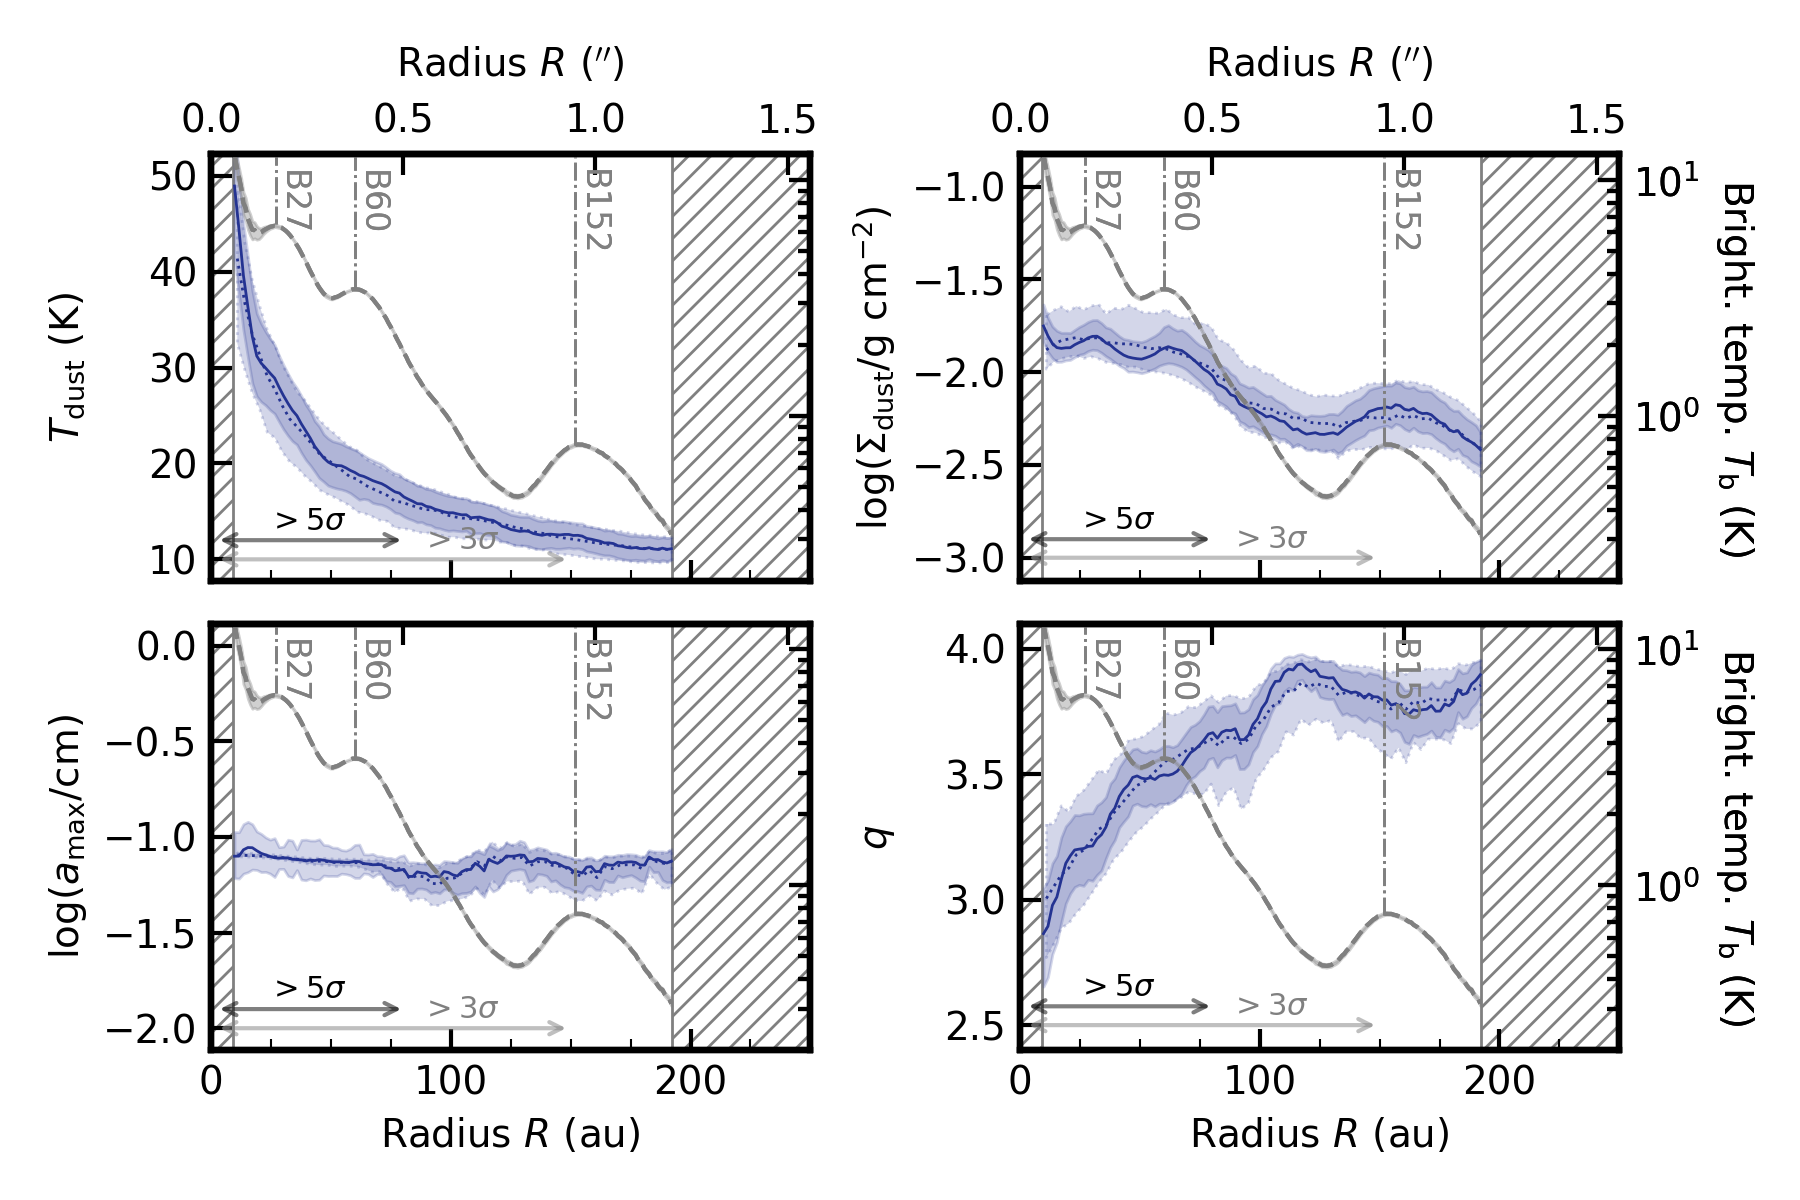

In [17]:
fig, axs = plt.subplots(2,2,figsize=(9.,6.),sharex='all')

axs = axs.ravel()

mainfig(axs=axs,filename='./Ricci/tapered_bandKa_nof_cut.dat', color=color1, ls=':', lw=1)
mainfig(axs=axs,filename='./Ricci/tapered_ALMA_nof_cut.dat', color=color1)

axs[3].set_xlim(0.,250.)
# axs[0].legend()

for i in range(len(axs)):
    axs[i].fill_betweenx(y=[-100,100],x1=0.,x2=0.058*disc_dist,hatch='///',fc='white',ec='gray',zorder=-1)
    axs[i].fill_betweenx(y=[-100,100],x1=1.2*disc_dist,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)

    axs[i].xaxis.set_ticks([0,100,200])
    axs[i].xaxis.set_minor_locator(MultipleLocator(25))
    axs[i].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[i].tick_params(axis='x',which='both',top=False,labeltop=False)

    # Build secondary axes to show radius in arcsec
    secax = axs[i].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    if i < 2:
        secax.set_xlabel("Radius $R\ ('')$",labelpad=9)
        
    else:
        secax.tick_params(axis='x',which='both',labeltop=False)
        axs[i].set_xlabel(r"Radius $R$ (au)")

color_text   = ['k','gray']
label        = [r'$>5\sigma$',r'$>3\sigma$']
yset         = [[12,-2.9,-1.9,2.575],[10,-3.0,-2.0,2.5  ]]
yset_label   = [[14,-2.8,-1.8,2.65 ],[12,-2.9,-1.9,2.575]]
xset_label   = [0.25*disc_dist,0.65*disc_dist]
snr          = [82.84432650000001,151.62074850000002]
bracketstyle = f"<->, angleB=0"

for idx in range(len(axs)):
    for j in range(len(label)):
        axs[idx].annotate(
            '', xy=(0.058,yset[j][idx]), xytext=(snr[j],yset[j][idx]), color=color_text[j], fontsize=11,
            arrowprops=dict(arrowstyle=bracketstyle, connectionstyle='arc3,rad=0', lw=1.5, color=color_text[j], alpha=0.5, 
                            shrinkA=3, shrinkB=3,), horizontalalignment="center", verticalalignment="center",
        )
        axs[idx].text(
            xset_label[j], yset_label[j][idx], label[j], fontsize=11, color=color_text[j],
            horizontalalignment="center", verticalalignment="center"
        )

fig.tight_layout()
plt.subplots_adjust(wspace=0.35,hspace=0.1)

#plt.savefig('results_fiducial.pdf',bbox_inches='tight')
plt.show()

<IPython.core.display.Javascript object>


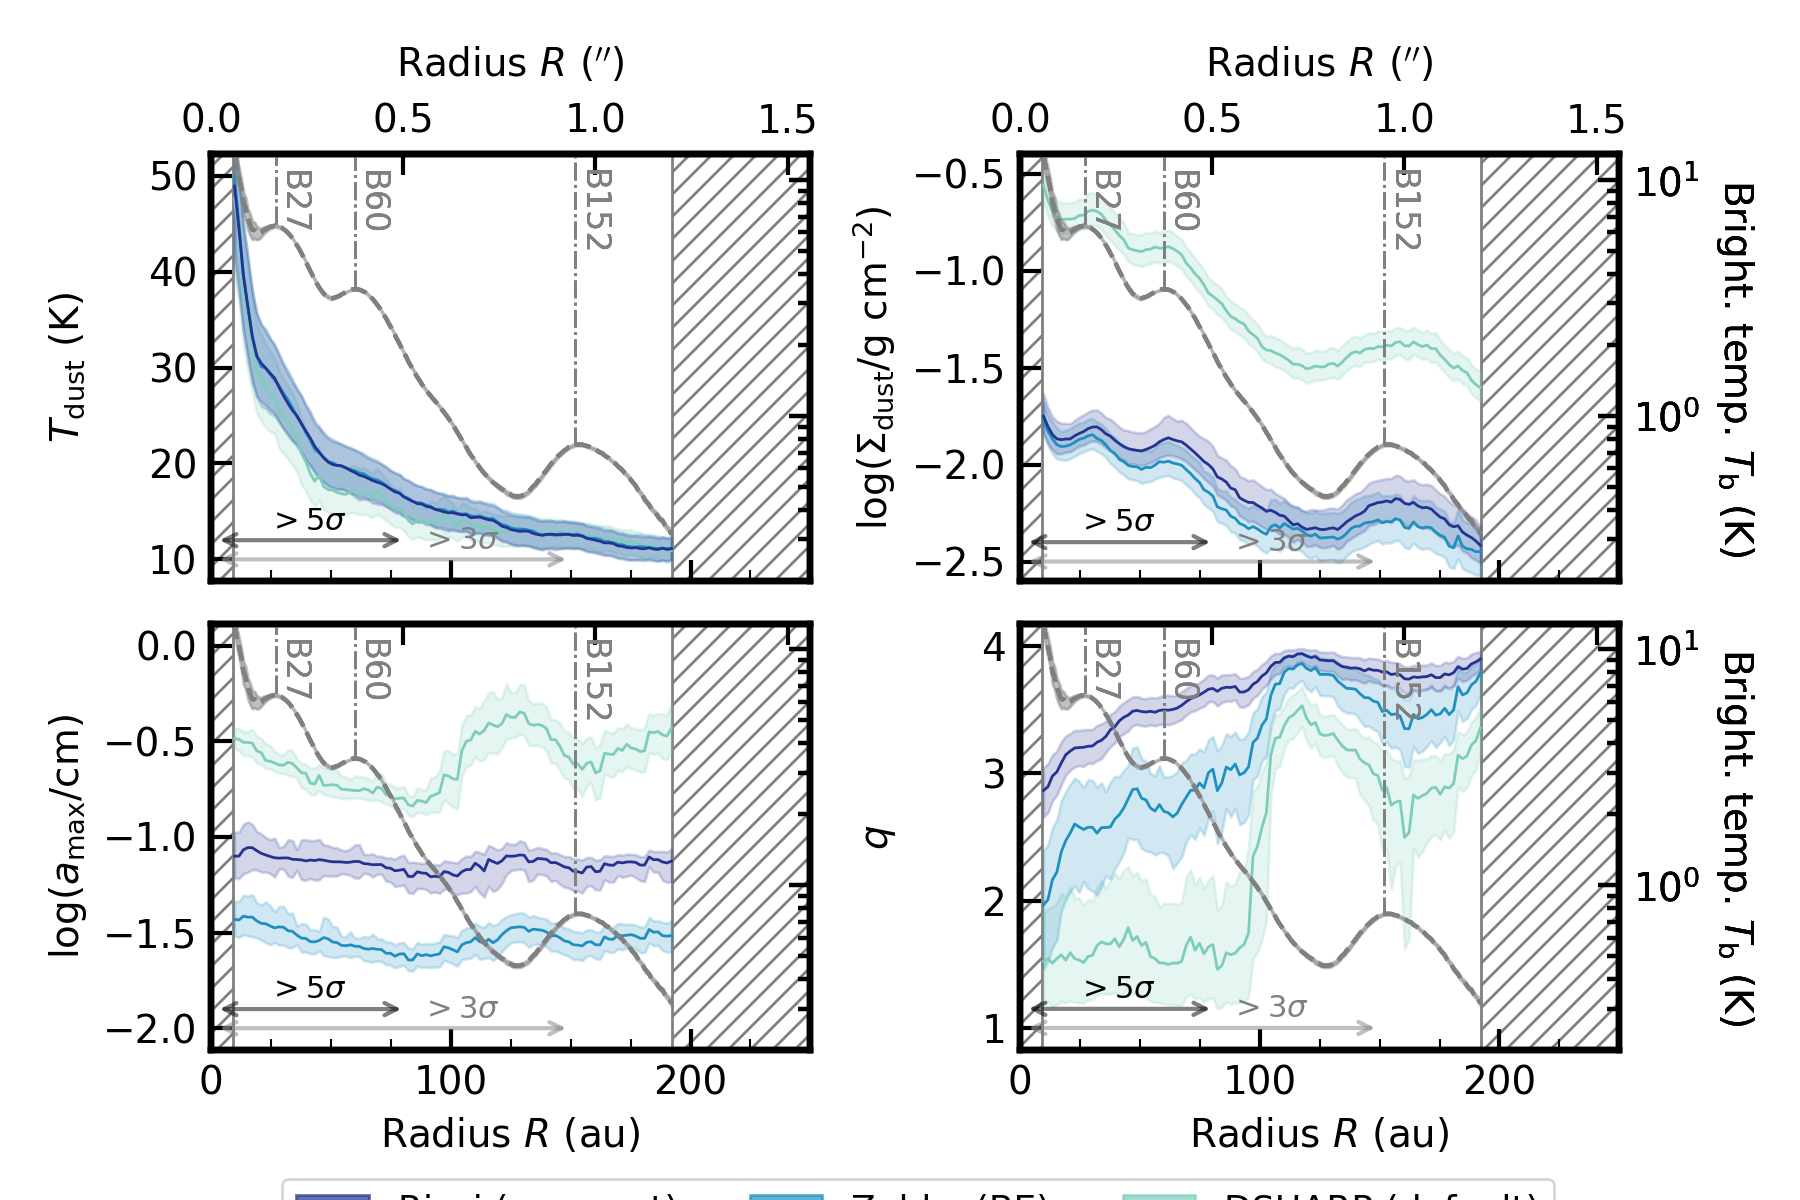

Median amax_fit  0.07355010606864075
Median amax_fit  0.029171971939557194
Median amax_fit  0.24829644215772306


In [18]:
fig, axs = plt.subplots(2,2,figsize=(9.,6.),sharex='all')

axs = axs.ravel()

mainfig(axs=axs,filename='./DSHARP/tapered_ALMA_nof_cut.dat',color=color3,label='DSHARP')
mainfig(axs=axs,filename='./Zubko/tapered_ALMA_nof_cut.dat',color=color2,label='Zubko')
mainfig(axs=axs,filename='./Ricci/tapered_ALMA_nof_cut.dat',color=color1,label='Ricci')

axs[3].set_xlim(0.,250.)
    
for i in range(len(axs)):
    axs[i].fill_betweenx(y=[-100,100],x1=0.,x2=0.058*disc_dist,hatch='///',fc='white',ec='gray',zorder=-1)
    axs[i].fill_betweenx(y=[-100,100],x1=1.2*disc_dist,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)

    axs[i].xaxis.set_ticks([0,100,200])
    axs[i].xaxis.set_minor_locator(MultipleLocator(25))
    axs[i].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[i].tick_params(axis='x',which='both',top=False,labeltop=False)

    # Build secondary axes to show radius in arcsec
    secax = axs[i].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    if i < 2:
        secax.set_xlabel("Radius $R\ ('')$",labelpad=9)
        
    else:
        secax.tick_params(axis='x',which='both',labeltop=False)
        axs[i].set_xlabel(r"Radius $R$ (au)")

color_text   = ['k','gray']
label        = [r'$>5\sigma$',r'$>3\sigma$']
yset         = [[12,-2.4,-1.9,1.15],[10,-2.5,-2.0,1.  ]]
yset_label   = [[14,-2.3,-1.8,1.30],[12,-2.4,-1.9,1.15]]
xset_label   = [0.25*disc_dist,0.65*disc_dist]
snr          = [82.84432650000001,151.62074850000002]
bracketstyle = f"<->, angleB=0"

for idx in range(len(axs)):
    for j in range(len(label)):
        axs[idx].annotate(
            '', xy=(0.058,yset[j][idx]), xytext=(snr[j],yset[j][idx]), color=color_text[j], fontsize=11,
            arrowprops=dict(arrowstyle=bracketstyle, connectionstyle='arc3,rad=0', lw=1.5, color=color_text[j], alpha=0.5, 
                            shrinkA=3, shrinkB=3,), horizontalalignment="center", verticalalignment="center",
        )
        axs[idx].text(
            xset_label[j], yset_label[j][idx], label[j], fontsize=11, color=color_text[j],
            horizontalalignment="center", verticalalignment="center"
        )

axs[1].set_ylim(-2.6,-0.4)
axs[3].set_ylim(0.825,4.175)

axs[3].set_ylabel(r'$q$',labelpad=30)

legend_elements = [
    mpatches.Patch(color=color1, label='Ricci (compact)' , alpha=0.7),
    mpatches.Patch(color=color2, label='Zubko (BE)' , alpha=0.7),
    mpatches.Patch(color=color3, label='DSHARP (default)', alpha=0.7),
]

fig.legend(handles=legend_elements, fontsize=13, loc='lower center', ncol=3, bbox_to_anchor=(0.51,-0.05))

fig.tight_layout()
plt.subplots_adjust(wspace=0.35,hspace=0.1)

#plt.savefig('results_comparison.pdf',bbox_inches='tight')
plt.show()

for filename in [
    './Ricci/','./Zubko/','./DSHARP/'
]:
    rad,medt,e16t,e84t,meds,e16s,e84s,meda,e16a,e84a,medq,e16q,e84q = np.loadtxt(
        filename+'tapered_ALMA_nof_cut.dat', skiprows=1, unpack=True
    )

    mask = np.logical_and(rad>0.058*disc_dist, rad<1.2*disc_dist)

    print('Median amax_fit ', np.median(10.**meda[mask]))

<IPython.core.display.Javascript object>


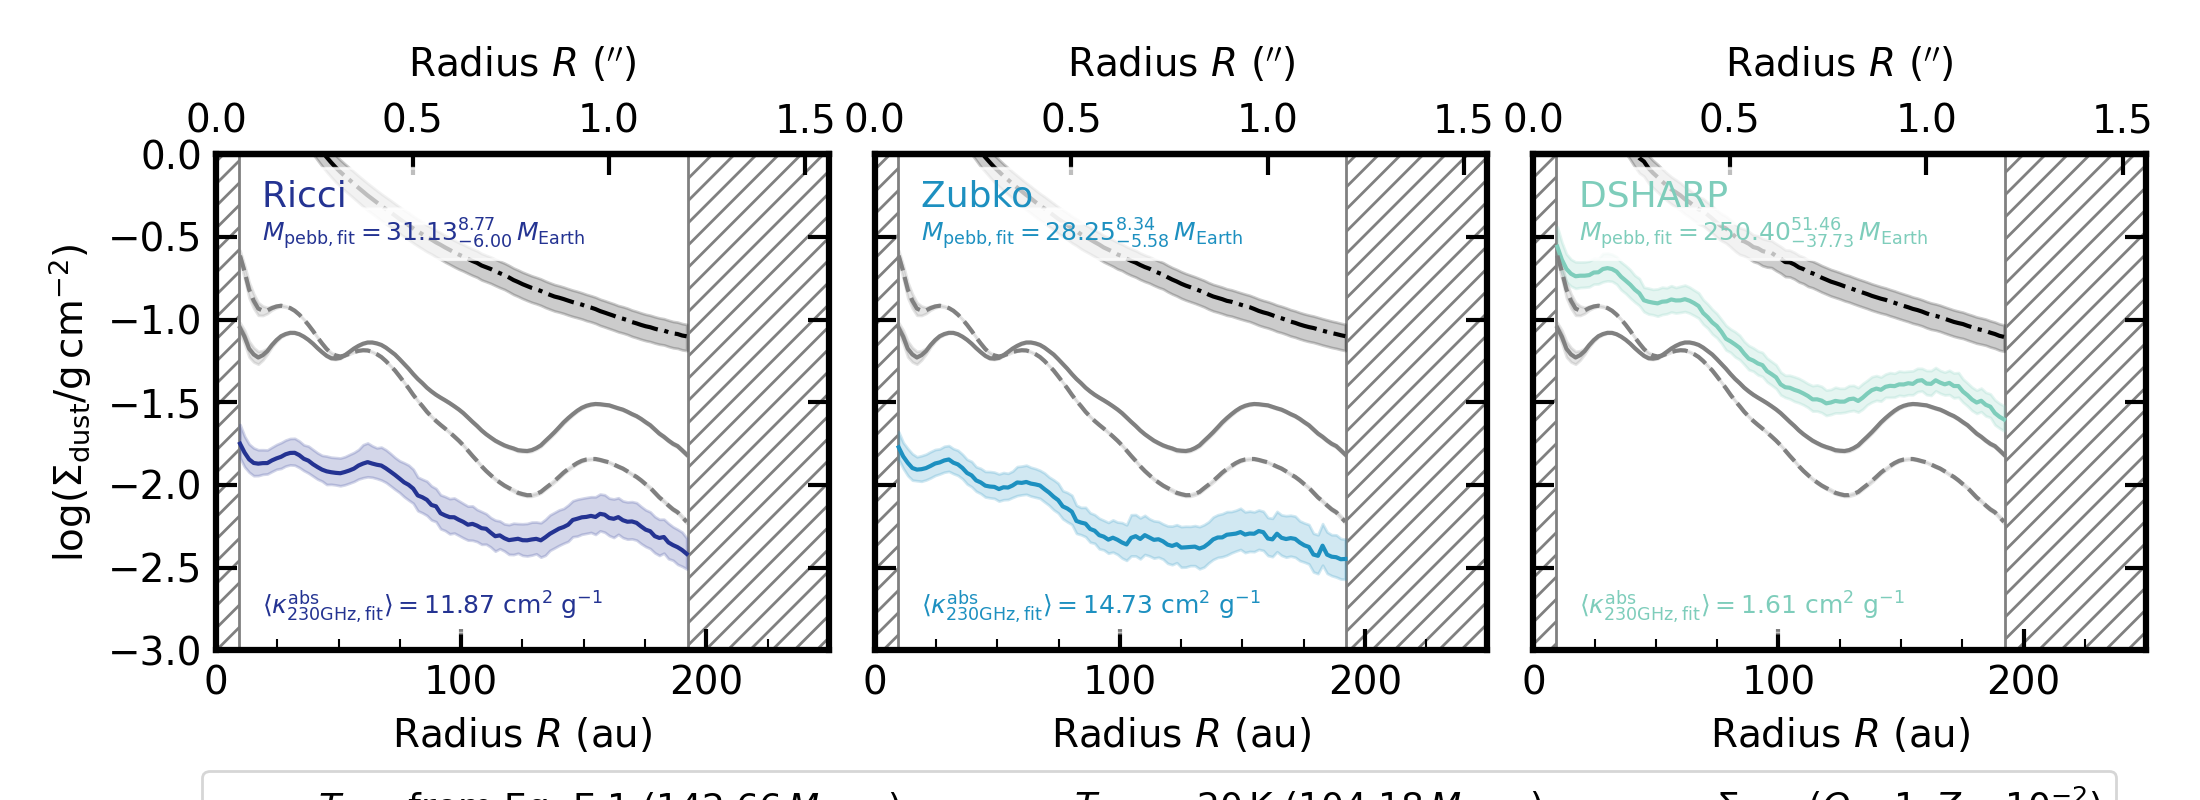

Median kappa_abs_fit (230 GHz) 11.86593855528765
Median kappa_abs_fit (230 GHz) 14.729043458039477
Median kappa_abs_fit (230 GHz) 1.6090379499066136


In [19]:
fig, axs = plt.subplots(1,3,figsize=(11,4),sharey='all',sharex='all')

rad_grid, inu_init, enu_init = np.loadtxt('./radprof_Band6.dat', unpack=True, skiprows=1)

temp_prof = (0.035*1.04*lsun/(8.*np.pi*s_SB*(rad_grid*au)**2))**0.25 #K

_surf_temp = surfdens_optthin(freq=freq_list[1],temp=temp_prof,bright_prof=inu_init)
esurf_temp = surfdens_optthin(freq=freq_list[1],temp=temp_prof,bright_prof=enu_init)

_surf = surfdens_optthin(freq=freq_list[1],temp=20.,bright_prof=inu_init)
esurf = surfdens_optthin(freq=freq_list[1],temp=20.,bright_prof=enu_init)

label = ['Ricci       ','Zubko     ','DSHARP    ']
for i,_path in enumerate(['./Ricci/','./Zubko/','./DSHARP/']):

    rad, temp, e16t, e84t, sigma, e16s, e84s = np.loadtxt(_path+'tapered_ALMA_nof_cut.dat',skiprows=1,unpack=True,usecols=(0,1,2,3,4,5,6))
    
    mask = np.logical_and(rad>0.058*disc_dist, rad<1.2*disc_dist)
    
    axs[i].plot(rad[mask],sigma[mask],color=color[i])
    axs[i].fill_between(rad[mask],e16s[mask],e84s[mask],alpha=0.2,color=color[i])
    
    mass    = (2.*np.pi*rad[rad<=200.]*(rad[1]-rad[0])*10.**sigma[rad<=200.]).sum()*au**2/m_ear
    mass_ep = (2.*np.pi*rad[rad<=200.]*(rad[1]-rad[0])*10.**e84s[rad<=200.] ).sum()*au**2/m_ear
    mass_em = (2.*np.pi*rad[rad<=200.]*(rad[1]-rad[0])*10.**e16s[rad<=200.] ).sum()*au**2/m_ear
    
    #t = axs[i].text(
    #    0.075,0.95,label[i] + f' (${{{mass:3.2f}}}^{{{mass_ep-mass:3.2f}}}_{{{mass_em-mass:3.2f}}}\,$' + 
    #    r'$M_{\rm Earth}$)',ha='left',va='top',transform=axs[i].transAxes,color=color[i],fontsize=13
    #)
    #t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w', boxstyle='round'))
    
    t = axs[i].text(
        0.075,0.95,label[i],ha='left',va='top',transform=axs[i].transAxes,color=color[i],fontsize=13
    )
    t.set_bbox(dict(facecolor='w', alpha=0.75, edgecolor='w', boxstyle='round'))
    t = axs[i].text(
        0.075,0.875,r'$M_{\rm pebb,fit} = $' + f'${{{mass:3.2f}}}^{{{mass_ep-mass:3.2f}}}_{{{mass_em-mass:3.2f}}}\,$' + # (R<200\,{\rm au})
        r'$M_{\rm Earth}$',ha='left',va='top',transform=axs[i].transAxes,color=color[i],fontsize=9
    )
    t.set_bbox(dict(facecolor='w', alpha=0.75, edgecolor='w', boxstyle='round'))
    
    sQ   = TQ( rad,temp)
    e16Q = eTQ(rad,temp,temp-e16t)
    e84Q = eTQ(rad,temp,e84t-temp)

    axs[i].plot(rad[mask], np.log10(sQ)[mask], ls='-.', color='k')
    axs[i].fill_between(rad[mask], np.log10(sQ-e16Q)[mask], np.log10(sQ+e84Q)[mask], alpha=0.2, color='k')

    axs[i].plot(rad[mask],np.log10(_surf_temp[:325:2][mask]),color='gray',ls='-')
    axs[i].fill_between(rad[mask],np.log10((_surf_temp[:325:2] - esurf_temp[:325:2])[mask]),np.log10((_surf_temp[:325:2] + esurf_temp[:325:2])[mask]),alpha=0.2,color='gray')
    
    axs[i].plot(rad[mask],np.log10(_surf[:325:2][mask]),color='gray',ls='--')
    axs[i].fill_between(rad[mask],np.log10((_surf[:325:2] - esurf[:325:2])[mask]),np.log10((_surf[:325:2] + esurf[:325:2])[mask]),alpha=0.2,color='gray')

axs[2].set_xlim(0,250)
axs[2].set_ylim(-3,0)
    
for i in range(len(axs)):
    axs[i].fill_betweenx(y=[-100,100],x1=0.,x2=0.058*disc_dist,hatch='///',fc='white',ec='gray',zorder=-1)
    axs[i].fill_betweenx(y=[-100,100],x1=1.2*disc_dist,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)

    axs[i].xaxis.set_ticks([0,100,200])
    axs[i].xaxis.set_minor_locator(MultipleLocator(25))
    axs[i].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[i].tick_params(axis='x',which='both',top=False,labeltop=False)

    # Build secondary axes to show radius in arcsec
    secax = axs[i].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    secax.set_xlabel("Radius $R\ ('')$",labelpad=9)
    axs[i].set_xlabel(r"Radius $R$ (au)")

axs[0].set_ylabel(r'$\log(\Sigma_{\rm dust}/{\rm g}\,{\rm cm}^{-2})$')

mass_temp = (2.*np.pi*rad_grid[rad_grid <= 200.]*(rad_grid[1]-rad_grid[0])*_surf_temp[rad_grid <= 200.]).sum()*au**2/m_ear
mass      = (2.*np.pi*rad_grid[rad_grid <= 200.]*(rad_grid[1]-rad_grid[0])*_surf[rad_grid <= 200.]).sum()*au**2/m_ear

legend_elements = [
    Line2D([0], [0], label=r'$T_{\rm dust}$ from Eq. E.1 '+f'(${{{mass_temp:3.2f}}}'+r'\,M_{\rm Earth}$)', ls='-', color='gray', lw=2),
    Line2D([0], [0], label=r'$T_{\rm dust} = 20\,{\rm K}$ '+f'(${{{mass:3.2f}}}$'+r'$\,M_{\rm Earth}$)', ls='--', color='gray', lw=2),
    Line2D([0], [0], label=r'$\Sigma_{\rm dust}\ (Q=1,Z=10^{-2})$', ls='-.', color='k', lw=2),
]

fig.legend(handles=legend_elements,loc='lower center',ncol=3,bbox_to_anchor=(0.527,-0.075),fontsize=13)

for i, filename in enumerate([
    './Ricci/','./Zubko/','./DSHARP/'
]):
    rad,opac6,e16o,e84o = np.loadtxt(
        filename+'optical_ALMA/absopacity_tapered_ALMA_nof_cut.dat', skiprows=1, unpack=True, usecols=(0,4,5,6)
    )

    mask = np.logical_and(rad>0.058*disc_dist, rad<1.2*disc_dist)

    print('Median kappa_abs_fit (230 GHz)',np.median(opac6[mask]))
    
    t = axs[i].text(
        0.075,0.125,r'$\langle\kappa_{\rm 230GHz,fit}^{\rm abs}\rangle = $'+f'{np.median(opac6[mask]):.2f}'+r' cm${^2}$ g$^{-1}$',
        ha='left',va='top',transform=axs[i].transAxes,color=color[i],fontsize=9
    )
    t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w', boxstyle='round'))

fig.tight_layout()
plt.subplots_adjust(wspace=0.075)

#plt.savefig('mass_comparison.pdf',bbox_inches='tight')
plt.show()

Check fit (brightness profiles):

In [20]:
interval    = np.linspace(-1.,3.,6)
cmap        = plt.get_cmap('magma') 
norm        = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap   = cm.ScalarMappable(norm=norm, cmap=cmap)

color_clean = scalarMap.to_rgba(interval[1])
color_frank = scalarMap.to_rgba(interval[3])

<IPython.core.display.Javascript object>


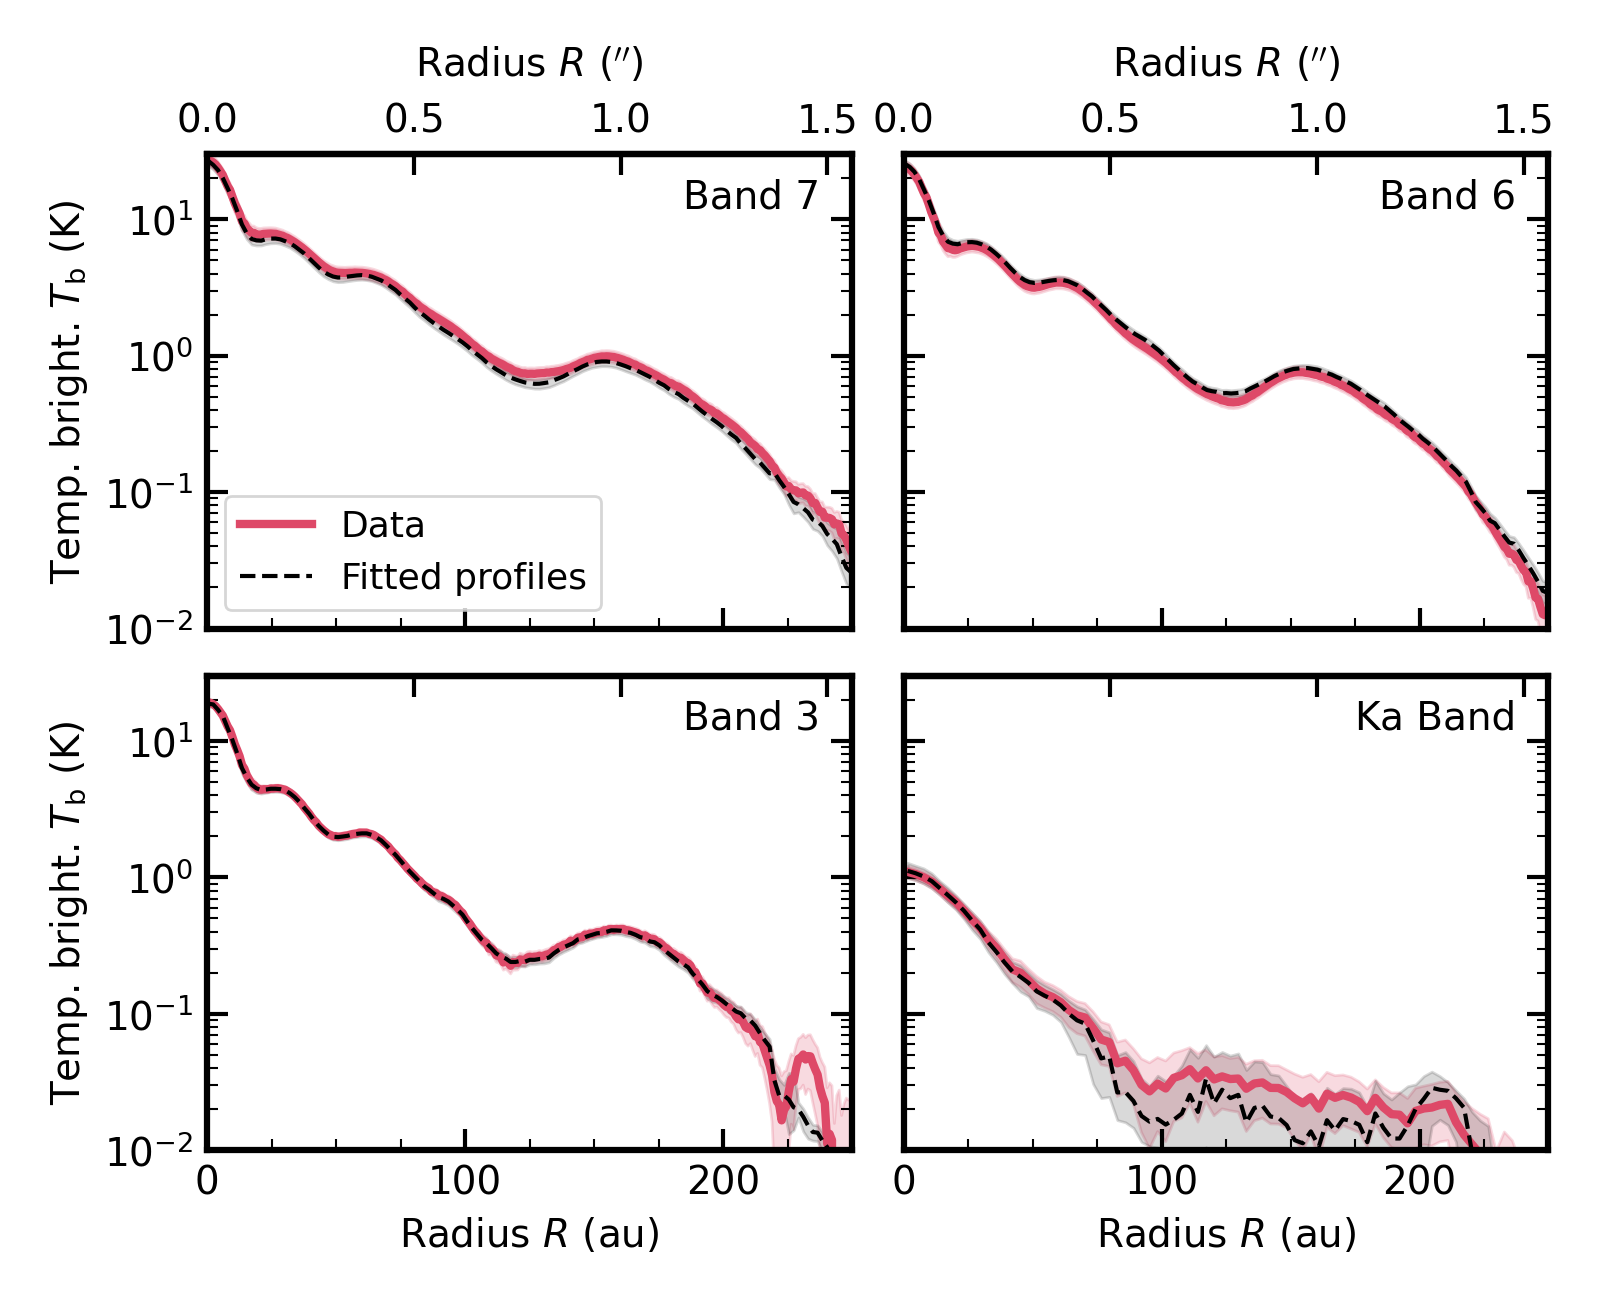

In [21]:
profiles_CITau = ['radprof_Band7.dat','radprof_Band6.dat','radprof_Band3.dat','radprof_BandKa.dat']

path           = ['./Ricci/optical_ALMA/','./Ricci/optical_ALMA/','./Ricci/optical_ALMA/','./Ricci/optical_VLA/']
 
name           = ['ALMA','ALMA','ALMA','BandKa']
    
label          = ['Band 7', 'Band 6', 'Band 3', 'Ka Band']

calerr         = [0.10,0.10,0.05,0.10]

fig, axs = plt.subplots(2,2,figsize=(8.,6.5),sharex='all',sharey='row')

axs = axs.ravel()

for idx in range(len(profiles_CITau)):

    x, y, dy = np.loadtxt(path[idx]+profiles_CITau[idx], skiprows=1, usecols=(0,1,2), unpack=True)
    
    y_b  = _jysr_to_tb(data=y, freq=freq_list[idx])
    dy_b = _jysr_to_tb(data=dy,freq=freq_list[idx])
        
    l, = axs[idx].semilogy(x, y_b, lw=3., label='Data', color=color_frank)
    axs[idx].fill_between(x, y_b - np.hypot(dy_b,y_b*calerr[idx]), y_b + np.hypot(dy_b,y_b*calerr[idx]), color=l.get_color(), alpha=0.2)

    axs[idx].set_xlim(0.,250.)
    axs[idx].set_ylim(1e-2,3e1)
    
    axs[idx].xaxis.set_ticks([0,100,200])
    axs[idx].xaxis.set_minor_locator(MultipleLocator(25))
    axs[idx].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[idx].tick_params(axis='x',which='both',top=False,labeltop=False)

    # Build secondary axes to show radius in arcsec
    secax = axs[idx].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    if idx < 2:
        secax.set_xlabel("Radius $R\ ('')$",labelpad=9)
        
    else:
        secax.tick_params(axis='x',which='both',labeltop=False)
        axs[idx].set_xlabel(r"Radius $R$ (au)")

    axs[idx].text(0.95, 0.95, s=label[idx], ha='right', va='top', transform=axs[idx].transAxes) #, bbox=dict(boxstyle="round", ec="k", fc="w",)

    rad, int_prof, e16, e84 = np.loadtxt(path[idx]+'intensity_tapered_{}_nof_cut.dat'.format(name[idx]),skiprows=1,unpack=True,usecols=(0,1+3*idx,2+3*idx,3+3*idx))

    e16 = _jysr_to_tb(data=e16,freq=freq_list[idx])
    int_prof = _jysr_to_tb(data=int_prof,freq=freq_list[idx])
    e84 = _jysr_to_tb(data=e84,freq=freq_list[idx])
    
    l, = axs[idx].semilogy(rad, int_prof, lw=1.5, ls='--', label='Fitted profiles', color='k')
    axs[idx].fill_between(rad, e16, e84, color=l.get_color(), alpha=0.15)

    if idx%2 == 0:
        axs[idx].set_ylabel(r'Temp. bright. $T_{\rm b}$ (K)')

axs[0].legend(loc='lower left',fontsize=13)

fig.tight_layout()
plt.subplots_adjust(wspace=0.08,hspace=0.1)

#plt.savefig('check_profiles.pdf',bbox_inches='tight')
plt.show()

Check fit (spectral indices):

In [22]:
interval  = np.linspace(-1.,3.,6)
cmap      = plt.get_cmap('plasma') 
Norm      = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap = cm.ScalarMappable(norm=Norm, cmap=cmap)

color1    = scalarMap.to_rgba(interval[1])
color2    = scalarMap.to_rgba(interval[3])
color3    = scalarMap.to_rgba(interval[4])

color     = [color1,color2,color3]

In [23]:
profiles_CITau = ['radprof_Band7.dat','radprof_Band6.dat','radprof_Band3.dat','radprof_Band3.dat','radprof_BandKa.dat']

path           = ['./Ricci/optical_ALMA/','./Ricci/optical_ALMA/','./Ricci/optical_ALMA/','./Ricci/optical_VLA/','./Ricci/optical_VLA/']
 
rad_data = np.zeros((5,163))
y_data   = np.zeros((5,163))
dy_data  = np.zeros((5,163))

for idx in range(len(profiles_CITau)):

    x, y, dy = np.loadtxt(path[idx]+profiles_CITau[idx], skiprows=1, usecols=(0,1,2), unpack=True)
    
    if idx < 3:
        rad_data[idx] = x[:325:2]
        y_data[idx]   = y[:325:2]
        dy_data[idx]  = np.hypot(dy,y*calerr[idx])[:325:2]
    else:
        rad_data[idx] = x[:163]
        y_data[idx]   = y[:163]
        dy_data[idx]  = np.hypot(dy,y*calerr[idx-1])[:163]

<IPython.core.display.Javascript object>


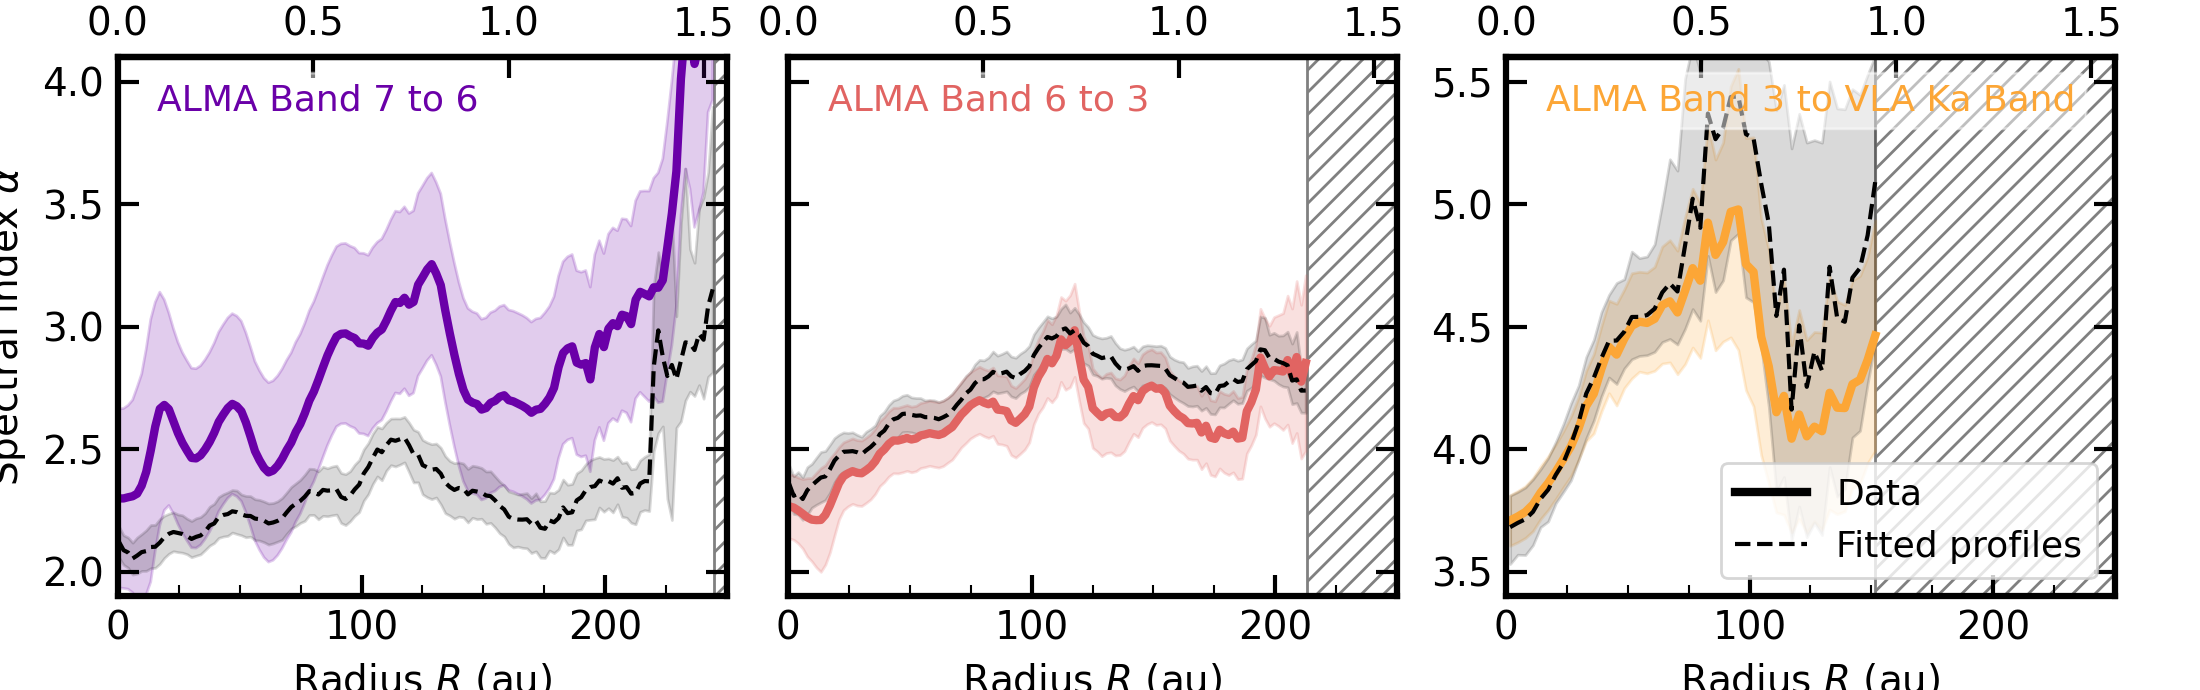

/var/folders/lz/yv59n4jx71vbz95j_0sxfsw00000gn/T/ipykernel_77136/1277984906.py:15: RuntimeWarning: invalid value encountered in log
  alpha76  = np.log(y_data[0]/y_data[1])/np.log(freq_list[0]/freq_list[1])
/var/folders/lz/yv59n4jx71vbz95j_0sxfsw00000gn/T/ipykernel_77136/1277984906.py:24: RuntimeWarning: invalid value encountered in log
  alpha63  = np.log(y_data[1]/y_data[2])/np.log(freq_list[1]/freq_list[2])
/var/folders/lz/yv59n4jx71vbz95j_0sxfsw00000gn/T/ipykernel_77136/1277984906.py:37: RuntimeWarning: invalid value encountered in log
  alpha3a  = np.log(y_data[3]/y_data[4])/np.log(freq_list[2]/freq_list[3])


In [24]:
fig, axs = plt.subplots(1,2,figsize=(11,3.45),gridspec_kw={"width_ratios":[2.25,1.]})

fig.tight_layout()

subplots_left = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=axs[0],wspace=0.1,width_ratios=[1,1])
axs = [plt.subplot(subplots_left[0]),plt.subplot(subplots_left[1]),axs[1]]

lim_spix = [244.5490772,212.9343676,151.62074850000002]

rad, a76_med, a76_e16, a76_e84, a63_med, a63_e16, a63_e84 = np.loadtxt(
    './Ricci/optical_ALMA/spectral_index_tapered_ALMA_nof_cut.dat', unpack=True, skiprows=1, usecols=(0,1,2,3,4,5,6) 
)

mask     = rad_data[0]<=lim_spix[0]
alpha76  = np.log(y_data[0]/y_data[1])/np.log(freq_list[0]/freq_list[1])
ealpha76 = np.hypot(dy_data[0]/y_data[0],dy_data[1]/y_data[1])/np.log(freq_list[0]/freq_list[1])
axs[0].plot(rad_data[0][mask],alpha76[mask],color=color[0],lw=3.)
axs[0].fill_between(rad_data[0][mask],(alpha76-ealpha76)[mask],(alpha76+ealpha76)[mask],alpha=0.2,color=color[0])

axs[0].plot(rad[mask],a76_med[mask],lw=1.5,c='k',ls='--')
axs[0].fill_between(rad[mask],(a76_e16)[mask],(a76_e84)[mask],color='k',alpha=0.15)

mask     = rad_data[1]<=lim_spix[1]
alpha63  = np.log(y_data[1]/y_data[2])/np.log(freq_list[1]/freq_list[2])
ealpha63 = np.hypot(dy_data[1]/y_data[1],dy_data[2]/y_data[2])/np.log(freq_list[1]/freq_list[2])
axs[1].plot(rad_data[1][mask],alpha63[mask],color=color[1],lw=3.)
axs[1].fill_between(rad_data[1][mask],(alpha63-ealpha63)[mask],(alpha63+ealpha63)[mask],alpha=0.2,color=color[1])

axs[1].plot(rad[mask],a63_med[mask],lw=1.5,c='k',ls='--')
axs[1].fill_between(rad[mask],(a63_e16)[mask],(a63_e84)[mask],color='k',alpha=0.15)

rad, a3a_med, a3a_e16, a3a_e84 = np.loadtxt(
    './Ricci/optical_VLA/spectral_index_tapered_BandKa_nof_cut.dat', unpack=True, skiprows=1, usecols=(0,7,8,9) 
)

mask     = rad_data[3]<=lim_spix[2]
alpha3a  = np.log(y_data[3]/y_data[4])/np.log(freq_list[2]/freq_list[3])
ealpha3a = np.hypot(dy_data[3]/y_data[3],dy_data[4]/y_data[4])/np.log(freq_list[2]/freq_list[3])
axs[2].plot(rad_data[3][mask],alpha3a[mask],color=color[2],lw=3.)
axs[2].fill_between(rad_data[3][mask],(alpha3a-ealpha3a)[mask],(alpha3a+ealpha3a)[mask],alpha=0.2,color=color[2])

mask     = rad<=lim_spix[2]
axs[2].plot(rad[mask],a3a_med[mask],lw=1.5,c='k',ls='--')
axs[2].fill_between(rad[mask],a3a_e16[mask],a3a_e84[mask],color='k',alpha=0.15)

for idx in range(len(axs)):
    axs[idx].fill_betweenx(y=[-100,100],x1=lim_spix[idx],x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)

    axs[idx].set_xlim(0.,250.)
    axs[idx].set_xlabel(r"Radius $R$ (au)")
    
    axs[idx].xaxis.set_ticks([0,100,200])
    axs[idx].xaxis.set_minor_locator(MultipleLocator(25))
    axs[idx].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[idx].tick_params(axis='x',which='both',top=False,labeltop=False)
    
    # Build secondary axes to show radius in arcsec
    secax = axs[idx].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    secax.set_xlabel("Radius $R\ ('')$", labelpad=8)
    
    axs[idx].set_ylim(1.9,4.1)

axs[0].set_ylabel(r"Spectral index $\alpha$") 
axs[1].tick_params(which='both',labelright=False,labelleft=False)

axs[2].set_ylim(3.4,5.6)

plt.subplots_adjust(wspace=0.02)

t = axs[0].text(
    0.065, 0.95, 'ALMA Band 7 to 6', ha='left', va='top', 
    transform=axs[0].transAxes, color=color1, fontsize=13,
)
t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w', boxstyle='round'))

t = axs[1].text(
    0.065, 0.95, 'ALMA Band 6 to 3', ha='left', va='top', 
    transform=axs[1].transAxes, color=color2, fontsize=13,
)
t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w', boxstyle='round'))

t = axs[2].text(
    0.065, 0.95, 'ALMA Band 3 to VLA Ka Band', ha='left', va='top',
    transform=axs[2].transAxes, color=color3, fontsize=13,
)
t.set_bbox(dict(facecolor='w', alpha=0.5, edgecolor='w', boxstyle='round'))

legend_elements = [
    Line2D([0], [0], label=r'Data', ls='-', color='k', lw=3),
    Line2D([0], [0], label=r'Fitted profiles', ls='--', color='k', lw=1.5),
]

axs[2].legend(handles=legend_elements,loc='lower right',fontsize=13)

#plt.savefig('check_spix.pdf',bbox_inches='tight')
plt.show()

Optical properties:

In [25]:
interval  = np.linspace(-1.,3.,8)
cmap      = plt.get_cmap('BuPu_r') 
Norm      = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap = cm.ScalarMappable(norm=Norm, cmap=cmap)

color1    = scalarMap.to_rgba(interval[1])
color2    = scalarMap.to_rgba(interval[2])
color3    = scalarMap.to_rgba(interval[3])
color4    = scalarMap.to_rgba(interval[4])

color     = [color1,color2,color3,color4]

In [26]:
def optfig(axs,color=color):
    
    for i,name in enumerate([
        './Ricci/optical_VLA/tau_tapered_BandKa_nof_cut',
        #'./Ricci/optical_VLA/absopacity_tapered_BandKa_nof_cut',
        './Ricci/optical_VLA/tauabs_tapered_BandKa_nof_cut',
        './Ricci/optical_VLA/albedo_tapered_BandKa_nof_cut',
        './Ricci/optical_VLA/opacity_tapered_BandKa_nof_cut',
        
    ]):
        
        rad,i7,i7_e16,i7_e84,i6,i6_e16,i6_e84,i3,i3_e16,i3_e84,iKa,iKa_e16,iKa_e84 = np.loadtxt(
            name+'.dat',skiprows=1,unpack=True,
        )
    
        mask = np.logical_and(rad>=0.058*disc_dist, rad<=1.2*disc_dist)
        
        for j,_i,_e16,_e84 in zip(
            [0,1,2,3],
            [i7,i6,i3,iKa],
            [i7_e16,i6_e16,i3_e16,iKa_e16],
            [i7_e84,i6_e84,i3_e84,iKa_e84]
        ):
            axs[i].plot(rad[mask],_i[mask],color=color[j],ls=':',lw=1)
            if j != 1:
                axs[i].fill_between(rad[mask],_e16[mask],_e84[mask],alpha=0.1,color=color[j],zorder=-1)
            else:
                axs[i].fill_between(rad[mask],_e16[mask],_e84[mask],alpha=0.2,color=color[j],zorder=-1)
                
    for i,name in enumerate([
        './Ricci/optical_ALMA/tau_tapered_ALMA_nof_cut',
        #'./Ricci/optical_ALMA/absopacity_tapered_ALMA_nof_cut'
        './Ricci/optical_ALMA/tauabs_tapered_ALMA_nof_cut',
        './Ricci/optical_ALMA/albedo_tapered_ALMA_nof_cut',
        './Ricci/optical_ALMA/opacity_tapered_ALMA_nof_cut',
    ]):
        rad,i7,i7_e16,i7_e84,i6,i6_e16,i6_e84,i3,i3_e16,i3_e84,iKa,iKa_e16,iKa_e84 = np.loadtxt(
            name+'.dat',skiprows=1,unpack=True,
        )
    
        mask = np.logical_and(rad>=0.058*disc_dist, rad<=1.2*disc_dist)
        
        for j,_i,_e16,_e84 in zip(
            [0,1,2],
            [i7,i6,i3],
            [i7_e16,i6_e16,i3_e16],
            [i7_e84,i6_e84,i3_e84]
        ):
            if i != 2:
                axs[i].semilogy(rad[mask],_i[mask],color=color[j])
            else:
                axs[i].plot(rad[mask],_i[mask],color=color[j])
            axs[i].fill_between(rad[mask],_e16[mask],_e84[mask],alpha=0.2,color=color[j])
            
    for i, fname in enumerate(['radprof_Band7.dat','radprof_Band6.dat','radprof_Band3.dat','radprof_BandKa.dat']):
        rad_grid, inu_init, enu_init = np.loadtxt(fname, unpack=True, skiprows=1)

        tmid = (0.02*1.04*lsun/(8.*np.pi*s_SB*(rad_grid*au)**2))**0.25
        tau  = -np.log(1.-inu_init/BlackBody(freq=freq_list[i],temp=tmid))*np.cos(disc_inc*np.pi/180.)
    
        mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)
        axs[1].plot(rad_grid[mask],tau[mask],color='k',lw=1,ls=':')
    
    rad_grid, inu_init, enu_init = np.loadtxt('./radprof_Band6.dat', unpack=True, skiprows=1)

    mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)
    
    for i in range(len(axs)):
        ays = axs[i].twinx()
        
        #axs[i].set_zorder(ays.get_zorder() + 1)
        axs[i].patch.set_visible(False)
        
        inu_init_b = _jysr_to_tb(data=inu_init,freq=freq_list[1])#-1e10
        enu_init_b = _jysr_to_tb(data=enu_init,freq=freq_list[1])#-1e10
        
        ays.semilogy(rad_grid[mask], inu_init_b[mask], color='gray', ls='--')
        ays.fill_between(rad_grid[mask], (inu_init_b - enu_init_b)[mask], (inu_init_b + enu_init_b)[mask], alpha=0.2, color='gray')
        
        #ays.set_ylim(4e8,2e10)
        ays.set_ylim(2e-1,np.amax(inu_init_b[mask]))
        if np.logical_or(i==0,i==2):
            ays.set_yticklabels([])
        else:
            ays.set_ylabel(r"Bright. temp. $T_{\rm b}$ (K)", rotation=270, labelpad=20) #,color='gray'
            
        ays.text(27, 6.25, f'B{27:1.0f}', fontsize=12, rotation=270, color='gray')
        ays.vlines(27,  6.5,  20,ls='-.', color='gray', lw=1)
        
        ays.text(60, 6.25, f'B{60:1.0f}', fontsize=12, rotation=270, color='gray')
        ays.vlines(60,  3.5,  20,ls='-.', color='gray', lw=1)
        
        ays.text(152, 5.1, f'B{152:1.0f}',fontsize=12, rotation=270, color='gray')
        ays.vlines(152, 0.75, 20,ls='-.', color='gray', lw=1)

<IPython.core.display.Javascript object>


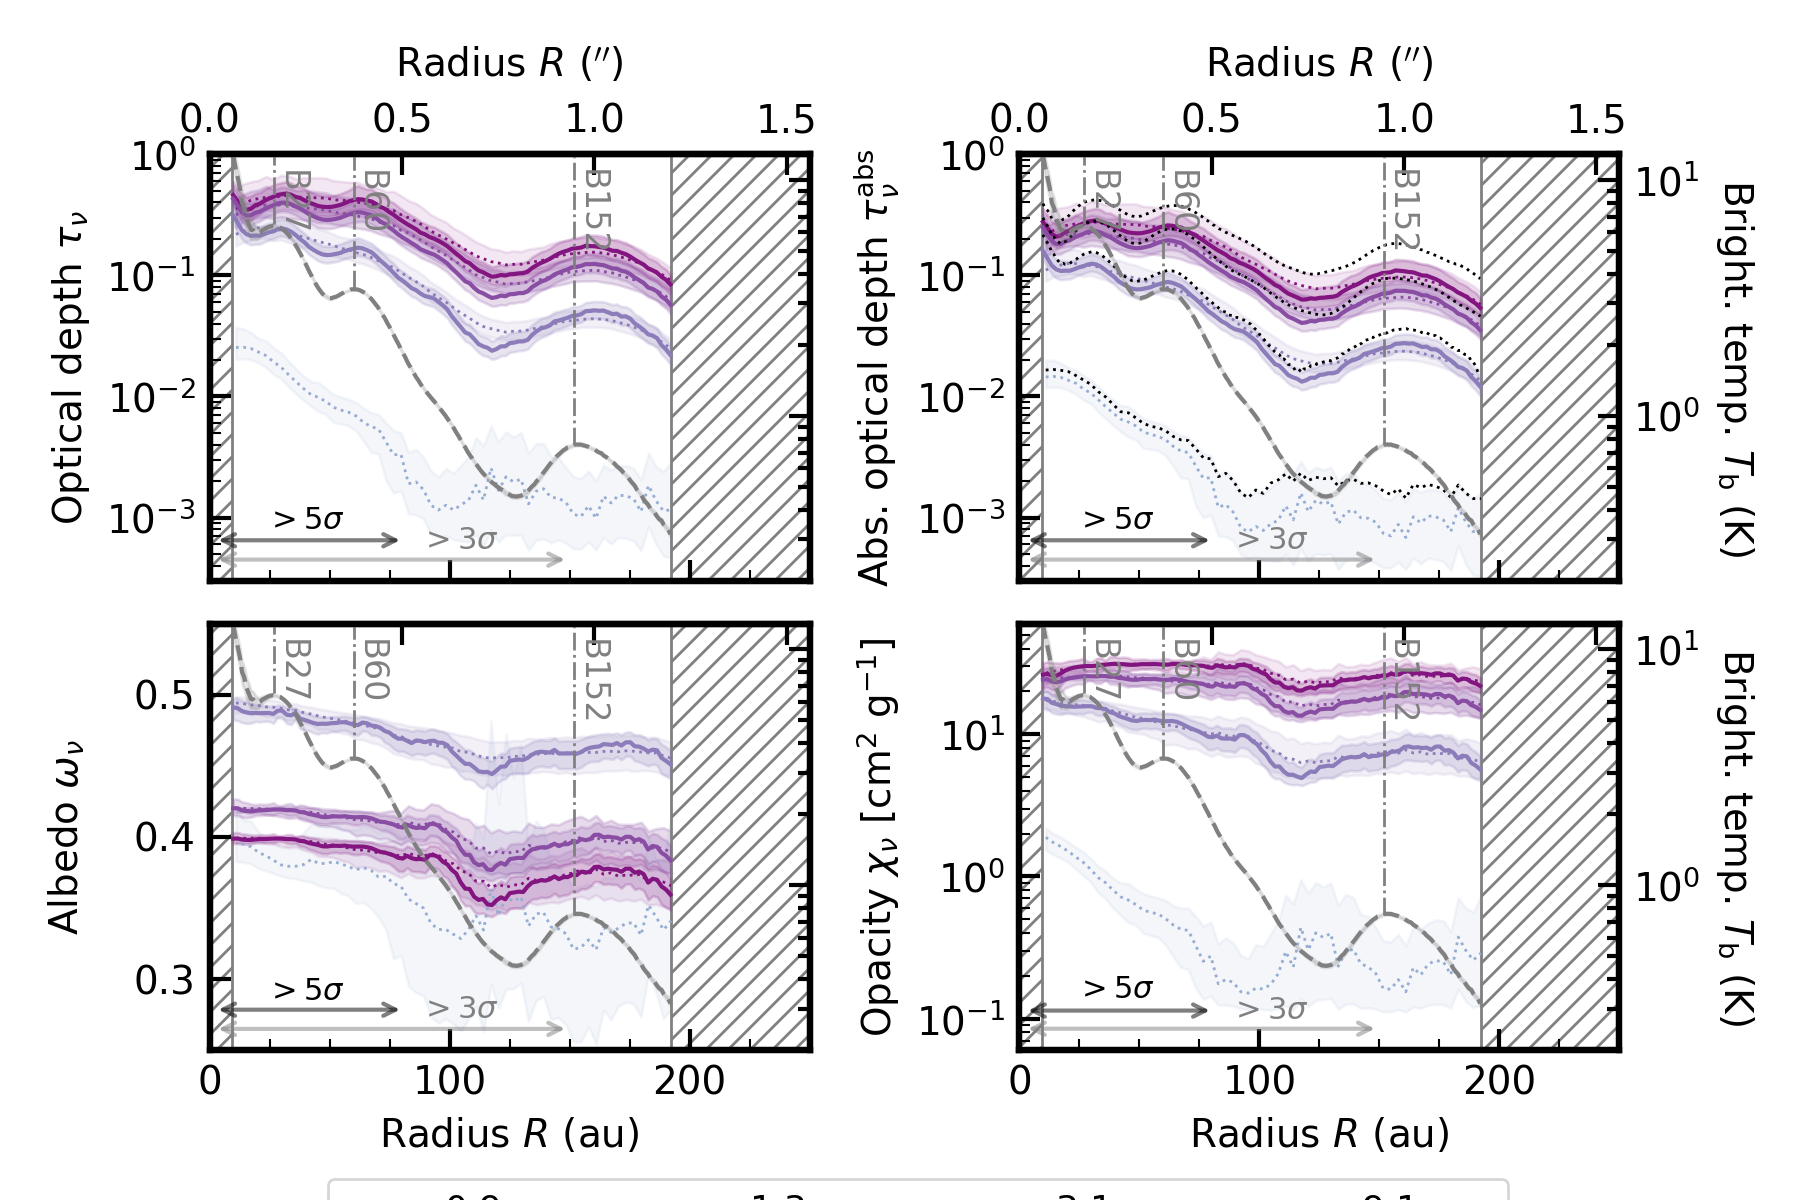

In [27]:
fig, axs = plt.subplots(2,2,figsize=(9.,6.),sharex='all')

axs = axs.ravel()

optfig(axs=axs)

axs[3].set_xlim(0.,250.)
    
for i in range(len(axs)):
    axs[i].fill_betweenx(y=[-100,100],x1=0.,x2=0.058*disc_dist,hatch='///',fc='white',ec='gray',zorder=-1)
    axs[i].fill_betweenx(y=[-100,100],x1=1.2*disc_dist,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)

    axs[i].xaxis.set_ticks([0,100,200])
    axs[i].xaxis.set_minor_locator(MultipleLocator(25))
    axs[i].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[i].tick_params(axis='x',which='both',top=False,labeltop=False)

    # Build secondary axes to show radius in arcsec
    secax = axs[i].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:
    if i < 2:
        secax.set_xlabel("Radius $R\ ('')$",labelpad=9)
        
    else:
        secax.tick_params(axis='x',which='both',labeltop=False)
        axs[i].set_xlabel(r"Radius $R$ (au)")

color_text = ['k','gray']
label      = [r'$>5\sigma$',r'$>3\sigma$']
yset       = [[6.5e-4,6.5e-4,0.2785,1.14e-1],[4.5e-4,4.5e-4,0.2650,8.5e-2]]
yset_label = [[9.4e-4,9.4e-4,0.2910,1.60e-1],[6.5e-4,6.5e-4,0.2785,1.14e-1]]
xset_label = [0.25*disc_dist,0.65*disc_dist]
snr        = [82.84432650000001,151.62074850000002]
bracketstyle = f"<->, angleB=0"

for idx in range(len(axs)):
    for j in range(len(label)):
        axs[idx].annotate(
            '', xy=(0.058,yset[j][idx]), xytext=(snr[j],yset[j][idx]), color=color_text[j], fontsize=11,
            arrowprops=dict(arrowstyle=bracketstyle, connectionstyle='arc3,rad=0', lw=1.5, color=color_text[j], alpha=0.5, 
                            shrinkA=3, shrinkB=3,), horizontalalignment="center", verticalalignment="center",
        )
        axs[idx].text(
            xset_label[j], yset_label[j][idx], label[j], fontsize=11, color=color_text[j],
            horizontalalignment="center", verticalalignment="center"
        )

axs[0].set_ylabel(r'Optical depth $\tau_\nu$')
axs[0].set_ylim(3e-4,1)
#axs[1].set_ylabel(r'Abs. opac. $\kappa^{\rm abs}_\nu$ [cm$^2$ g$^{-1}$]')
#axs[1].set_ylim(6e-2,6e1)
axs[1].set_ylabel(r'Abs. optical depth $\tau^{\rm abs}_\nu$')
axs[1].set_ylim(3e-4,1)
axs[2].set_ylabel(r'Albedo $\omega_\nu$',labelpad=17)
axs[2].set_ylim(0.25,0.55)
axs[3].set_ylabel(r'Opacity $\chi_\nu$ [cm$^2$ g$^{-1}$]')
axs[3].set_ylim(6e-2,6e1)

legend_elements = [
    Line2D([0], [0], label=r'$0.9\,{\rm mm}$', ls='-', color=color1, lw=2),
    Line2D([0], [0], label=r'$1.3\,{\rm mm}$', ls='-', color=color2, lw=2),
    Line2D([0], [0], label=r'$3.1\,{\rm mm}$', ls='-', color=color3, lw=2),
    Line2D([0], [0], label=r'$9.1\,{\rm mm}$', ls='-', color=color4, lw=2),
]

fig.legend(handles=legend_elements,loc='lower center',ncol=4,bbox_to_anchor=(0.51,-0.05),fontsize=13)

fig.tight_layout()
plt.subplots_adjust(wspace=0.35,hspace=0.1)

plt.savefig('results_optprop_fiducial_abs.pdf',bbox_inches='tight')
plt.show()

In [28]:
interval  = np.linspace(-1.,3.,8)
cmap      = plt.get_cmap('bwr') 
Norm      = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap = cm.ScalarMappable(norm=Norm, cmap=cmap)

color1    = scalarMap.to_rgba(interval[1])
color2    = scalarMap.to_rgba(interval[2])
color3    = scalarMap.to_rgba(interval[3])
color4    = scalarMap.to_rgba(interval[4])

color     = [color1,color2,color3,color4]

<IPython.core.display.Javascript object>


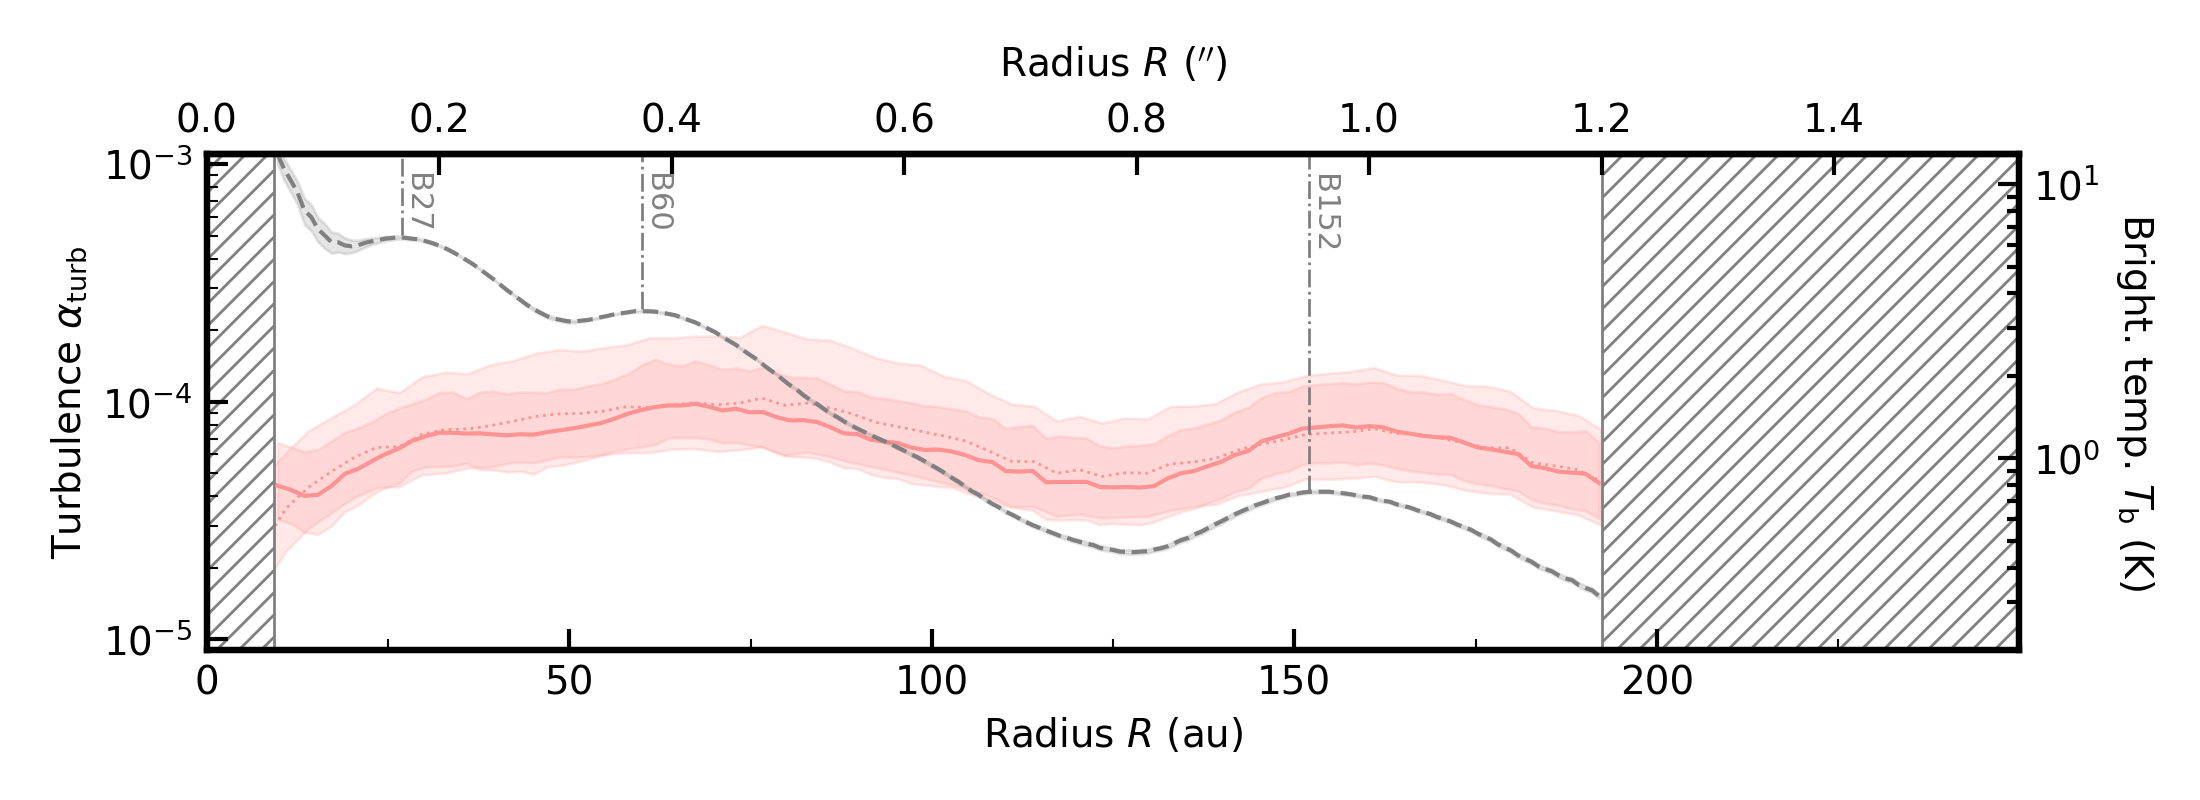

In [29]:
fig, axs = plt.subplots(figsize=(11,4))

rad_grid, alpha01, e16, e84, = np.loadtxt('./Ricci/optical_ALMA/turb_tapered_ALMA_nof_cut.dat',unpack=True,usecols=(0,1,2,3),skiprows=1)
mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)

l, = axs.semilogy(rad_grid[mask], alpha01[mask]/0.37, c=scalarMap.to_rgba(interval[5]))
axs.fill_between(rad_grid[mask], e16[mask]/0.37, e84[mask]/0.37, color=l.get_color(), alpha=0.2)

rad_grid, alpha01, e16, e84, = np.loadtxt('./Ricci/optical_VLA/turb_tapered_bandKa_nof_cut.dat',unpack=True,usecols=(0,1,2,3),skiprows=1)
mask = np.logical_and(rad_grid>0.048*disc_dist, rad_grid<1.2*disc_dist)

l, = axs.semilogy(rad_grid[mask], alpha01[mask]/0.37, ls=':', lw=1, c=scalarMap.to_rgba(interval[5]), zorder=-2)
axs.fill_between(rad_grid[mask], e16[mask]/0.37, e84[mask]/0.37, color=l.get_color(), alpha=0.2, zorder=-2)

#xx = np.linspace(0.058*disc_dist,1.2*disc_dist,100)
#axs.plot(xx,5e-4*xx**-0.5,ls='--',lw=1,c='k',label=r'$\propto R^{-0.5}$')

axs.set_xlim(0.,250.)
axs.set_ylim(9e-6,1.1e-3)

axs.fill_betweenx(y=[-100,100],x1=0.,x2=0.058*disc_dist,hatch='///',fc='white',ec='gray',zorder=-1)
axs.fill_betweenx(y=[-100,100],x1=1.2*disc_dist,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)

axs.xaxis.set_ticks([0,50,100,150,200])
axs.xaxis.set_minor_locator(MultipleLocator(25))
axs.tick_params(which='minor', color='k', length=4., width=0.75)
axs.tick_params(axis='x',which='both',top=False,labeltop=False)

# Build secondary axes to show radius in arcsec
secax = axs.secondary_xaxis('top', functions=(dist_arcsec, dist_au))
# secax.xaxis.set_minor_locator(MultipleLocator(0.25))
# secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
#if idx == 0:

secax.set_xlabel("Radius $R\ ('')$",labelpad=9)

axs.set_xlabel(r"Radius $R$ (au)")

axs.set_ylabel(r'Turbulence $\alpha_{\rm turb}$')

#axs.text(175,4.3e-4,r'$\propto R^{0.5}$',fontsize=13)

rad_grid, inu_init, enu_init = np.loadtxt('./radprof_Band6.dat', unpack=True, skiprows=1)
mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)

ays = axs.twinx()
axs.patch.set_visible(False)

inu_init_b = _jysr_to_tb(data=inu_init,freq=freq_list[1])#-1e10
enu_init_b = _jysr_to_tb(data=enu_init,freq=freq_list[1])#-1e10

ays.semilogy(rad_grid[mask], inu_init_b[mask], color='gray', ls='--')
ays.fill_between(rad_grid[mask], (inu_init_b - enu_init_b)[mask], (inu_init_b + enu_init_b)[mask], alpha=0.2, color='gray')

ays.set_ylim(2e-1,np.amax(inu_init_b[mask]))
ays.set_ylabel(r"Bright. temp. $T_{\rm b}$ (K)", rotation=270, labelpad=20) #,color='gray'
    
ays.text(27, 7.0, f'B{27:1.0f}', fontsize=11, rotation=270, color='gray')
ays.vlines(27,  6.5,  20,ls='-.', color='gray', lw=1)

ays.text(60, 7.0, f'B{60:1.0f}', fontsize=11, rotation=270, color='gray')
ays.vlines(60,  3.5,  20,ls='-.', color='gray', lw=1)

ays.text(152, 5.9, f'B{152:1.0f}',fontsize=11, rotation=270, color='gray')
ays.vlines(152, 0.75, 20,ls='-.', color='gray', lw=1)

fig.tight_layout()

plt.savefig('turbulence.pdf', bbox_inches='tight')
plt.show()

#follow haochang, assuming d2g=100, and uf=1m/s (notice that alpha scales with uf^2) scales as R^1/2 as expected from sigma dust propto R-1 in outer disc.

In [30]:
interval  = np.linspace(-1.,3.,8)
cmap      = plt.get_cmap('cool') 
Norm      = colors.Normalize(vmin=interval[0], vmax=interval[-1])
scalarMap = cm.ScalarMappable(norm=Norm, cmap=cmap)

color1    = scalarMap.to_rgba(interval[1])
color2    = scalarMap.to_rgba(interval[2])
color3    = scalarMap.to_rgba(interval[3])
color4    = scalarMap.to_rgba(interval[4])

color     = [color1,color2,color3,color4]

<IPython.core.display.Javascript object>


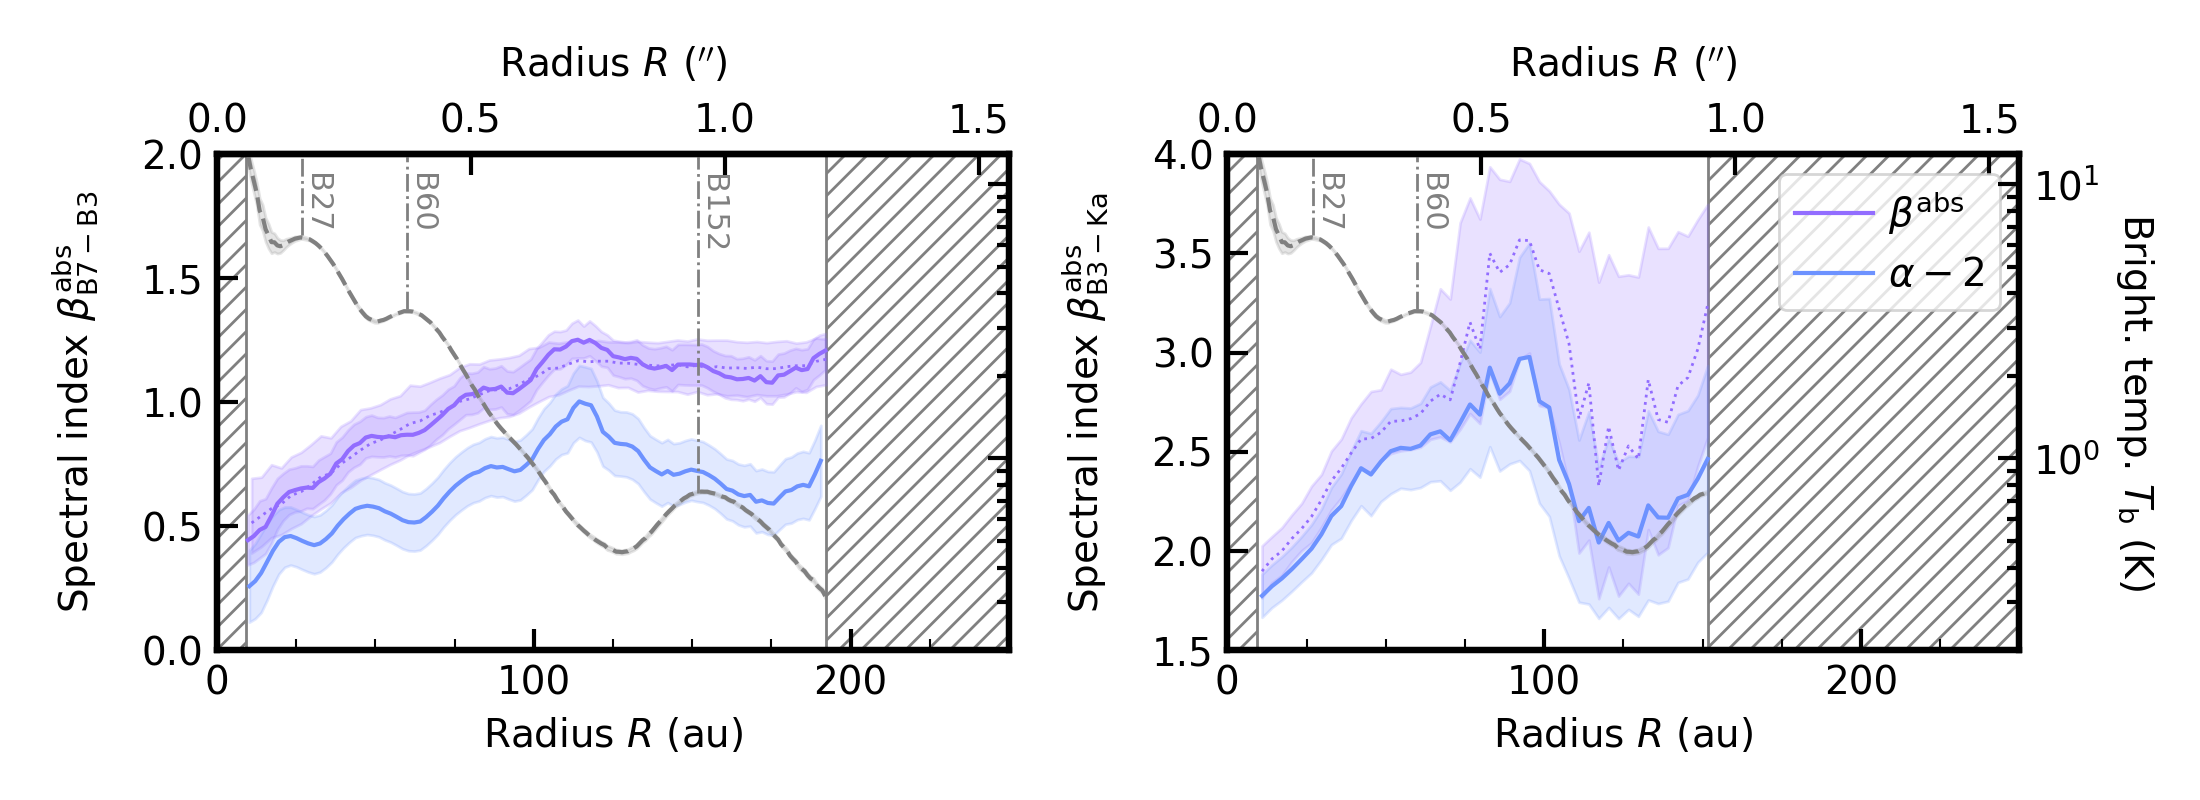

In [31]:
fig, axs = plt.subplots(1,2,figsize=(11,4))

rad_grid, b73, b73_e16, b73_e84, b3Ka, b3Ka_e16, b3Ka_e84 = np.loadtxt('./Ricci/optical_ALMA/beta_tapered_ALMA_nof_cut.dat',unpack=True,usecols=(0,1,2,3,4,5,6),skiprows=1)

mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)

l, = axs[0].plot(rad_grid[mask], b73[mask], c=color4, label=r'$\beta^{\rm abs}$')
axs[0].fill_between(rad_grid[mask], b73_e16[mask], b73_e84[mask], color=l.get_color(), alpha=0.2)

l, = axs[1].plot(rad_grid[mask], b73[mask], c=color4, label=r'$\beta^{\rm abs}$')
axs[1].fill_between(rad_grid[mask], b73_e16[mask], b73_e84[mask], color=l.get_color(), alpha=0.2)

rad_grid, b73, b73_e16, b73_e84, b3Ka, b3Ka_e16, b3Ka_e84 = np.loadtxt('./Ricci/optical_VLA/beta_tapered_bandKa_nof_cut.dat',unpack=True,usecols=(0,1,2,3,4,5,6),skiprows=1)

mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<1.2*disc_dist)

l, = axs[0].plot(rad_grid[mask], b73[mask], ls=':', lw=1, c=color4)
axs[0].fill_between(rad_grid[mask], b73_e16[mask], b73_e84[mask], color=l.get_color(), alpha=0.2)

mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<152.6207485)

l, = axs[1].plot(rad_grid[mask], b3Ka[mask], ls=':', lw=1, c=color4)
axs[1].fill_between(rad_grid[mask], b3Ka_e16[mask], b3Ka_e84[mask], color=l.get_color(), alpha=0.2)

rad, a73, ea73 = np.loadtxt('../../images_sameres/spectral_indices_ALMA.dat',skiprows=1,usecols=(0,5,6),unpack=True)
mask = np.logical_and(rad>0.058*disc_dist, rad<1.2*disc_dist)

l, = axs[0].plot(rad[mask], a73[mask] - 2., c=color3, label=r'$\alpha-2$')
axs[0].fill_between(rad[mask], (a73-ea73)[mask] - 2., (a73+ea73)[mask] - 2., color=l.get_color(), alpha=0.2)

rad, a3Ka, ea3Ka = np.loadtxt('../../images_sameres/spectral_indices_VLA.dat',skiprows=1,usecols=(0,1,2),unpack=True)
mask = np.logical_and(rad>0.058*disc_dist, rad<152.6207485)

l, = axs[1].plot(rad[mask], a3Ka[mask] - 2., c=color3, label=r'$\alpha-2$')
axs[1].fill_between(rad[mask], (a3Ka-ea3Ka)[mask] - 2., (a3Ka+ea3Ka)[mask] - 2., color=l.get_color(), alpha=0.2)

#beta63_guilloteau = [5.470543487049949, 0.28118306689430383, 5.8559871546600855, 0.2934775725593668, 6.248471085308303, 0.3063844482383984, 6.659471738843648, 0.3164650007760361, 7.074728928924711, 0.3289950333695484, 7.5856839889299374, 0.33914410283182606, 8.06897839170476, 0.35403939676134333, 8.604752533705403, 0.36573723420766724, 9.182807665469698, 0.37727805370169176, 9.825763424637135, 0.3874485347029193, 10.444282423698983, 0.40031258730405095, 11.137051748332926, 0.4114294583268665, 11.884258465963788, 0.42461896632003726, 12.665137305337453, 0.4352961870764136, 13.514866290001812, 0.44685270836566815, 14.402887459606273, 0.4564412713194337, 15.235059976943933, 0.4649033835169951, 15.917703750520536, 0.47223032748719485, 17.325422456794186, 0.49012571783330694, 18.802611175661177, 0.5042619897563241, 20.40574698277896, 0.519809095142014, 21.6971777318162, 0.5306410057426658, 29.864575982683235, 0.5862207046406949, 32.19063107561515, 0.5984774173521645, 34.935247387089895, 0.6140152103057577, 37.91387336055352, 0.6295483470433025, 40.96650009801231, 0.6429524289927053, 43.41092244092939, 0.6505154603618053, 46.356547718139396, 0.6625953748253919, 48.888690135363476, 0.6723932950488904, 52.55550492526468, 0.6844051683998138, 56.08610957723028, 0.6954749340369395, 59.81018538685033, 0.7053670650318176, 63.87479548243806, 0.7150236690982463, 68.06629069773682, 0.729626338662114, 72.86666945419523, 0.7403596372585974, 76.74856358995903, 0.7483899839619226, 83.45466991704171, 0.7670448548812672, 90.5701268270046, 0.7797656371255632, 98.96474327488676, 0.7968782658182014, 105.9184412341589, 0.8095975698986722, 113.922108460178, 0.818891044544467, 121.48645142308683, 0.8285476486108956, 129.64773978203382, 0.8430325547105386, 138.17771801449152, 0.8546387983513546, 147.4579082135805, 0.8663418697294221, 156.65277516719192, 0.8782438305137359, 167.69021968155954, 0.8903970200217293, 178.66802679276316, 0.9013254695017849, 190.49168557249862, 0.9131691093323875, 199.94315823706532, 0.9215807853484403]
#axs[0].plot(beta63_guilloteau[::2],beta63_guilloteau[1::2],c='k',ls='--')

#beta63_guilloteau = [5.361345558585455, 0.4888707124010556, 5.749166557796234, 0.48302964457550845, 6.1296273759262485, 0.48302964457550845, 6.563974463588854, 0.48464468637059066, 6.987409570051951, 0.4858559677169021, 7.456813883991952, 0.4867980754307, 7.963567721950397, 0.48750465621604855, 8.492342674164709, 0.4893888716436443, 9.069469488692013, 0.4905665062858917, 9.67874364966088, 0.49197966785658864, 10.336496487184544, 0.4940994102126339, 11.030887733821322, 0.49551257178333086, 11.763330445177361, 0.49786784106782567, 12.56274866092017, 0.4992810026385226, 13.41649413429123, 0.5018717988514667, 14.317795276216447, 0.5046981219928606, 15.317963743623832, 0.5069860978692269, 16.306109514841967, 0.509879714418749, 17.40153094006522, 0.5129415644885924, 18.570541230722373, 0.5174165761291325, 19.81808398294105, 0.5214205339127735, 21.160473900172853, 0.5269049466752402, 22.5867186308757, 0.5301350302654044, 24.121678002418484, 0.5372008381188889, 25.742138288922437, 0.5430890113301259, 27.4513970557061, 0.5494482383982617, 29.31695264442263, 0.5562785193232966, 31.30928858051198, 0.5645219618190285, 33.41260240214265, 0.5725298773863108, 35.74663712550224, 0.5828930622380879, 38.05261518512115, 0.5920786124476176, 40.60893617153526, 0.6022062703709452, 43.67752751155579, 0.6122329881820803, 46.62145229118829, 0.6226971131460501, 49.7897759542577, 0.6340024057116251, 53.1345828370838, 0.6464853329194475, 56.74552904010186, 0.6603814216979669, 60.51338980982314, 0.6756592684567231, 64.83385529918286, 0.6824424439960681, 68.83862004559853, 0.6939919867096651, 73.45713852722533, 0.7110197113146051, 78.60215196165316, 0.7322171348750584, 83.82127617816522, 0.7508237622225673, 89.51764383152019, 0.7833264783485956, 95.60112804908992, 0.8226594753996588, 101.92769434805814, 0.8625644664198135, 108.79775962459348, 0.9032096849293809, 116.19149146620506, 0.9451334781933882, 123.99707188775668, 0.9882349060996432, 131.84454895201566, 1.0301586993636507, 140.07492699352179, 1.0633679962750273, 149.36609785953166, 1.0921964923172436, 160.0303669264363, 1.1225323607015367, 170.64518225975104, 1.1496231914049704, 182.09410333842993, 1.1752903926742202, 194.05895856931735, 1.1994502216013934, 207.07875597495888, 1.223526307620674, 220.9720772093053, 1.2465556072912896, 235.62915660270596, 1.2679937917119357, 252.45233644089194, 1.2921117491851624, 269.197501644542, 1.3129218617966099, 287.25849176505204, 1.3329992239639923, 305.66160966114256, 1.3516529566971909, 326.8846740613884, 1.3721699691310123, 348.58957241115337, 1.3912214806767036, 371.7115211345758, 1.4089331056961045, 398.25055330756203, 1.427775259972063, 424.6665152336722, 1.4437701553796543, 453.1582274126141, 1.460372186869471, 480.03061896640287, 1.473857785858407]
#axs[0].plot(beta63_guilloteau[::2],beta63_guilloteau[1::2],c='k',ls='--')

axs[0].set_ylim(0,2)
axs[1].set_ylim(1.5,4)

#rad, int_prof3, int_profKa = np.loadtxt('./Ricci/optical_VLA/intensity_tapered_bandKa_nof_cut.dat',skiprows=1,unpack=True,usecols=(0,7,10))

#alpha = np.log10(int_prof3/int_profKa)/np.log10(freq_list[2]/freq_list[3])
#axs[1].plot(rad, alpha-2, ls='--', c='k')

for i in range(len(axs)):
    axs[i].set_xlim(0.,250.)
    
    axs[i].fill_betweenx(y=[-100,100],x1=0.,x2=0.058*disc_dist,hatch='///',fc='white',ec='gray',zorder=-1)
    if i == 0:
        axs[i].fill_betweenx(y=[-100,100],x1=1.2*disc_dist,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)
    else:
        axs[i].fill_betweenx(y=[-100,100],x1=151.6207485,x2=2.*disc_dist, hatch='///',fc='white',ec='gray',zorder=-1)
    
    axs[i].xaxis.set_ticks([0,100,200])
    axs[i].xaxis.set_minor_locator(MultipleLocator(25))
    axs[i].tick_params(which='minor', color='k', length=4., width=0.75)
    axs[i].tick_params(axis='x',which='both',top=False,labeltop=False)

    # Build secondary axes to show radius in arcsec
    secax = axs[i].secondary_xaxis('top', functions=(dist_arcsec, dist_au))
    # secax.xaxis.set_minor_locator(MultipleLocator(0.25))
    # secax.xaxis.tick_params(which='minor', color='w', length=3., width=1.)
    #if idx == 0:

    secax.set_xlabel("Radius $R\ ('')$",labelpad=9)
    axs[i].set_xlabel(r"Radius $R$ (au)")

axs[0].set_ylabel(r'Spectral index $\beta^{\rm abs}_{\rm B7-B3}$',labelpad=15)
axs[1].set_ylabel(r'Spectral index $\beta^{\rm abs}_{\rm B3-Ka}$',labelpad=15)

#axs.legend(loc='upper left', handletextpad=0.075)
#axs.text(175,1e-4,r'$\propto R^{0.5}$',fontsize=13)

for i, max_rad in enumerate([1.2*disc_dist,151.6207485]):
    rad_grid, inu_init, enu_init = np.loadtxt('./radprof_Band6.dat', unpack=True, skiprows=1)
    mask = np.logical_and(rad_grid>0.058*disc_dist, rad_grid<max_rad)

    ays = axs[i].twinx()

    # axs[i].set_zorder(ays.get_zorder() + 1)
    axs[i].patch.set_visible(False)

    inu_init_b = _jysr_to_tb(data=inu_init,freq=freq_list[1])#-1e10
    enu_init_b = _jysr_to_tb(data=enu_init,freq=freq_list[1])#-1e10

    ays.semilogy(rad_grid[mask], inu_init_b[mask], color='gray', ls='--')
    ays.fill_between(rad_grid[mask], (inu_init_b - enu_init_b)[mask], (inu_init_b + enu_init_b)[mask], alpha=0.2, color='gray')

    ays.set_ylim(2e-1,np.amax(inu_init_b[mask]))
    if i == 1:
        ays.set_ylabel(r"Bright. temp. $T_{\rm b}$ (K)", rotation=270, labelpad=20) #,color='gray'

    ays.text(27, 7.0, f'B{27:1.0f}', fontsize=11, rotation=270, color='gray')
    ays.vlines(27,  6.5,  20,ls='-.', color='gray', lw=1)

    ays.text(60, 7.0, f'B{60:1.0f}', fontsize=11, rotation=270, color='gray')
    ays.vlines(60,  3.5,  20,ls='-.', color='gray', lw=1)
    
    if i == 0:
        ays.text(152, 5.9, f'B{152:1.0f}',fontsize=11, rotation=270, color='gray')
        ays.vlines(152, 0.75, 20,ls='-.', color='gray', lw=1)
        ays.set_yticklabels([])
    else:
        continue  

axs[1].legend(loc='upper right', handletextpad=0.4)

fig.tight_layout()

plt.savefig('beta_absorption.pdf', bbox_inches='tight')
plt.show()

#trend qualitatively similar to Guilloteau+11, but higher beta in outer disc, most likely due to higher SNR, especially in B3
#73 difference due mostly to optical depth correction, 3Ka to fit preferring upper end of distribution